In [1]:
import warnings
import ssl

from scipy.interpolate import splev, splrep
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Countries

## Data

In [2]:
owid = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv', parse_dates=['date'])
owid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210455 entries, 0 to 210454
Data columns (total 67 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   iso_code                                    210455 non-null  object        
 1   continent                                   198302 non-null  object        
 2   location                                    210455 non-null  object        
 3   date                                        210455 non-null  datetime64[ns]
 4   total_cases                                 201906 non-null  float64       
 5   new_cases                                   201575 non-null  float64       
 6   new_cases_smoothed                          200398 non-null  float64       
 7   total_deaths                                183142 non-null  float64       
 8   new_deaths                                  183064 non-null  float64      

The correct way of taking the actual value of cumulative cases/deaths is to compute the latest date (for each country) first;
```
last_date = owid[['iso_code', 'date']].groupby('iso_code').max()
```
but **supposing there aren't** that many **errors**, the fact that the total quantities are cumulative functions simplifies the operation.

In [3]:
df_owid = owid[['iso_code', 'stringency_index', 'population', 'population_density']].groupby('iso_code').mean()
# monotonic increasing functions
df_owid['cases'] = owid[['iso_code', 'total_cases']].groupby('iso_code').max()
df_owid['deaths'] = owid[['iso_code', 'total_deaths']].groupby('iso_code').max()

df_owid.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, ABW to ZWE
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stringency_index    181 non-null    float64
 1   population          242 non-null    float64
 2   population_density  213 non-null    float64
 3   cases               229 non-null    float64
 4   deaths              226 non-null    float64
dtypes: float64(5)
memory usage: 11.4+ KB


In [4]:
df_owid['prop_case'] = df_owid['cases'] / df_owid['population']
df_owid['prop_death'] = df_owid['deaths'] / df_owid['population']

## Visualization

In [5]:
# countries (and position in plot)

# cases
col_drop = ['population', 'population_density', 'deaths', 'prop_case', 'prop_death']

min_case = df_owid.sort_values(by='cases').drop(columns=col_drop).dropna().head()
min_case['iso_code'] = min_case.index
max_case = df_owid.sort_values(by='cases').drop(columns=col_drop).dropna().tail()
max_case['iso_code'] = max_case.index

# deaths
col_drop = ['population', 'population_density', 'cases', 'prop_case', 'prop_death']

min_death = df_owid.sort_values(by='deaths').drop(columns=col_drop).dropna().head()
min_death['iso_code'] = min_death.index
max_death = df_owid.sort_values(by='deaths').drop(columns=col_drop).dropna().tail()
max_death['iso_code'] = max_death.index

# proportions
col_drop = ['population', 'population_density', 'cases', 'deaths', 'prop_death']
max_propc = df_owid.sort_values(by='prop_case').drop(columns=col_drop).dropna().tail()
max_propc['iso_code'] = max_propc.index

col_drop = ['population', 'population_density', 'cases', 'deaths', 'prop_case']
max_propd = df_owid.sort_values(by='prop_death').drop(columns=col_drop).dropna().tail()
max_propd['iso_code'] = max_propd.index

# policy index
col_drop.pop()
max_ind = df_owid.sort_values(by='stringency_index').drop(columns=col_drop).dropna().tail()
max_ind['iso_code'] = max_ind.index

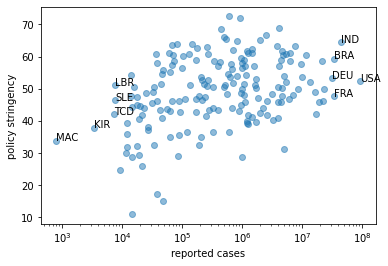

In [6]:
fig, ax = plt.subplots()
ax.semilogx(df_owid['cases'], df_owid['stringency_index'], 'o', alpha=0.5)
ax.set(xlabel="reported cases", ylabel="policy stringency")
# text annotations
for idx in min_case.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_case.values:
  ax.text(idx[1], idx[0], idx[2])

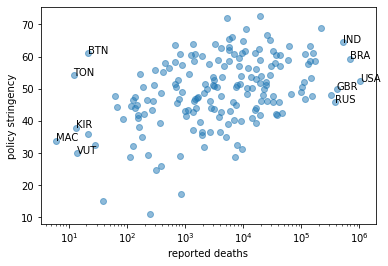

In [7]:
fig, ax = plt.subplots()
ax.semilogx(df_owid['deaths'], df_owid['stringency_index'], 'o', alpha=0.5)
ax.set(xlabel="reported deaths", ylabel="policy stringency")
# text annotations
for idx in min_death.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_death.values:
  ax.text(idx[1], idx[0], idx[2])

Problem with the different sizes in populations of the countries and with **underreporting** the number of cases and deaths in certain countries.


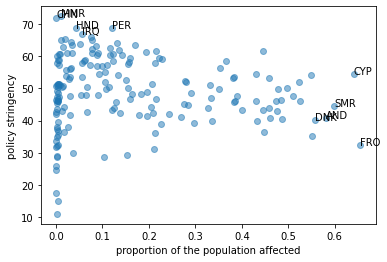

In [8]:
fig, ax = plt.subplots()
ax.plot(df_owid['prop_case'], df_owid['stringency_index'], 'o', alpha=0.5)
ax.set(xlabel="proportion of the population affected", ylabel="policy stringency")
# text annotations
for idx in max_propc.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_ind.values:
  ax.text(idx[1], idx[0], idx[3])

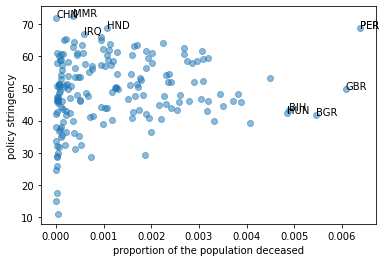

In [9]:
fig, ax = plt.subplots()
ax.plot(df_owid['prop_death'], df_owid['stringency_index'], 'o', alpha=0.5)
ax.set(xlabel="proportion of the population deceased", ylabel="policy stringency")
# text annotations
for idx in max_propd.values:
  ax.text(idx[1], idx[0], idx[2])
for idx in max_ind.values:
  ax.text(idx[2], idx[0], idx[3])

Consider **outliers**, possibly non representative values for countries on the bottom left of the plots.

## Selection

List of countries and corresponding ISO codes.

In [10]:
cc_dict = {k:v for k, v in zip(owid['iso_code'].unique(), owid['location'].unique())}
for iso in cc_dict:
  print(f'{iso:9} => {cc_dict[iso]}')

AFG       => Afghanistan
OWID_AFR  => Africa
ALB       => Albania
DZA       => Algeria
AND       => Andorra
AGO       => Angola
AIA       => Anguilla
ATG       => Antigua and Barbuda
ARG       => Argentina
ARM       => Armenia
ABW       => Aruba
OWID_ASI  => Asia
AUS       => Australia
AUT       => Austria
AZE       => Azerbaijan
BHS       => Bahamas
BHR       => Bahrain
BGD       => Bangladesh
BRB       => Barbados
BLR       => Belarus
BEL       => Belgium
BLZ       => Belize
BEN       => Benin
BMU       => Bermuda
BTN       => Bhutan
BOL       => Bolivia
BES       => Bonaire Sint Eustatius and Saba
BIH       => Bosnia and Herzegovina
BWA       => Botswana
BRA       => Brazil
VGB       => British Virgin Islands
BRN       => Brunei
BGR       => Bulgaria
BFA       => Burkina Faso
BDI       => Burundi
KHM       => Cambodia
CMR       => Cameroon
CAN       => Canada
CPV       => Cape Verde
CYM       => Cayman Islands
CAF       => Central African Republic
TCD       => Chad
CHL       => Chil

Interesting final objectives for analysis. Potential targets.

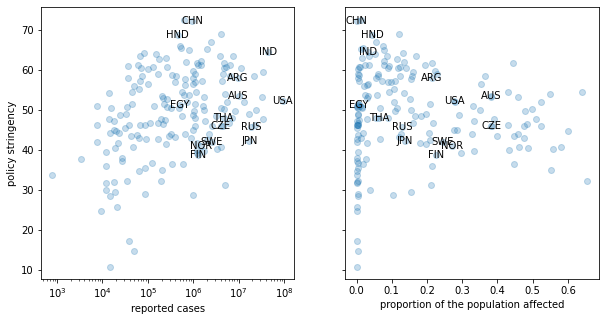

In [11]:
ccs = [ # country codes
       'ARG', 'AUS', 'CHN', 'CZE', 'EGY', 'FIN', 'HND', 
       'IND', 'JPN', 'NOR', 'RUS', 'SWE', 'THA', 'USA'
       ]

# plot
text_prop = {'va': 'center', 'ha': 'center'}

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10,5))
axs[0].semilogx(df_owid['cases'], df_owid['stringency_index'], 'o', alpha=0.25)
axs[0].set(xlabel="reported cases", ylabel="policy stringency")
axs[1].scatter(df_owid['prop_case'], df_owid['stringency_index'], alpha=0.25)
axs[1].set_xlabel('proportion of the population affected')
for cc in ccs:
  axs[0].text(df_owid.loc[cc, 'cases'], df_owid.loc[cc, 'stringency_index'], cc, text_prop)
  axs[1].text(df_owid.loc[cc, 'prop_case'], df_owid.loc[cc, 'stringency_index'], cc, text_prop)

Issue with big (geographically speaking) countries. Explore ratio with respect to cities. May be more representative. It may not be a relevant issue however.

## Population

For a more reliable estimate of country population, we can extract the data from a direct source.

*It will be used later.*

In [12]:
cc_dict['CZE'] = 'Czech Republic' # instead of Czechia

In [13]:
ssl._create_default_https_context = ssl._create_unverified_context
# read_html() retrieves a list of dfs
pop_df = pd.read_html(
    'https://worldpopulationreview.com/countries', header=0, index_col=1
)[0].reindex(cc_dict.values())
pop_df.dropna(inplace=True)
pop_df

,Rank,2022 Population,2021 Population,Growth Rate,Area,Density (km²)
Country,,,,,,
Afghanistan,37.0,41128771.0,40099462.0,2.57%,652230.0,63/km²
Albania,141.0,2842321.0,2854710.0,-0.43%,28748.0,99/km²
Algeria,35.0,44903225.0,44177969.0,1.64%,2381741.0,19/km²
Andorra,198.0,79824.0,79034.0,1.00%,468.0,171/km²
Angola,43.0,35588987.0,34503774.0,3.15%,1246700.0,29/km²
...,...,...,...,...,...,...
Vietnam,16.0,98186856.0,97468029.0,0.74%,331212.0,296/km²
Western Sahara,175.0,575986.0,565581.0,1.84%,266000.0,2/km²
Yemen,47.0,33696614.0,32981641.0,2.17%,527968.0,64/km²


# Policies

## Data

In [14]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
    oxcgrt = pd.read_csv(
        'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker-legacy/main/legacy_data_202207/OxCGRT_latest.csv',
        dtype={'RegionName': str, 'RegionCode': str} # avoid error warning
    )
oxcgrt.head()

,CountryName,CountryCode,RegionName,RegionCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,ABW,NaN,NaN,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
oxcgrt.drop(oxcgrt.columns[[2, 3]], axis=1, inplace=True) # region information

oxcgrt['Date'] = pd.to_datetime(oxcgrt['Date'], format='%Y%m%d')
oxcgrt = oxcgrt[oxcgrt['Jurisdiction'] == 'NAT_TOTAL']    # only national status

oxcgrt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180455 entries, 0 to 328400
Data columns (total 59 columns):
 #   Column                                                                           Non-Null Count   Dtype         
---  ------                                                                           --------------   -----         
 0   CountryName                                                                      180455 non-null  object        
 1   CountryCode                                                                      180455 non-null  object        
 2   Jurisdiction                                                                     180455 non-null  object        
 3   Date                                                                             180455 non-null  datetime64[ns]
 4   C1_School closing                                                                177097 non-null  float64       
 5   C1_Flag                                                   

Range of time available.

In [16]:
print(oxcgrt['Date'].min(), '<--->', oxcgrt['Date'].max())
print(oxcgrt['Date'].max() - oxcgrt['Date'].min())

2020-01-01 00:00:00 <---> 2022-08-22 00:00:00
964 days 00:00:00


### Pivoting

In [17]:
stringent = oxcgrt.pivot(index='Date', columns='CountryCode', values='StringencyIndex')
stringent.head()

CountryCode,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,...,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
cases = oxcgrt.pivot(index='Date', columns='CountryCode', values='ConfirmedCases')
cases[50:55] # first values are NA

CountryCode,ABW,AFG,AGO,ALB,AND,ARE,ARG,AUS,AUT,AZE,...,USA,UZB,VEN,VIR,VNM,VUT,YEM,ZAF,ZMB,ZWE
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-20,0.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,0.0,0.0,...,14.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-21,0.0,0.0,0.0,0.0,0.0,9.0,0.0,15.0,0.0,0.0,...,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,...,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,...,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0
2020-02-24,0.0,5.0,0.0,0.0,0.0,13.0,0.0,15.0,0.0,0.0,...,16.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0


In [19]:
idch = list(oxcgrt.columns[4:19:2])
idch.append(oxcgrt.columns[24])
idch.append(oxcgrt.columns[30])

C1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[0])
C2 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[1])
C3 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[2])
C4 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[3])
C5 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[4])
C6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[5])
C7 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[6])
C8 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[7])
H1 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[8])
H6 = oxcgrt.pivot(index='Date', columns='CountryCode', values=idch[9])

print('\n'.join(idch))

C1_School closing
C2_Workplace closing
C3_Cancel public events
C4_Restrictions on gatherings
C5_Close public transport
C6_Stay at home requirements
C7_Restrictions on internal movement
C8_International travel controls
H1_Public information campaigns
H6_Facial Coverings


## Selection

### Policies

Correlation of the different containment policy types. Can be used to supress highly correlated policies.

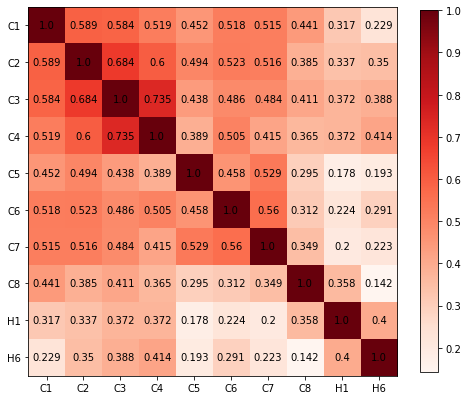

In [20]:
from img.plt import heatmap

mask = oxcgrt['CountryCode'].isin(cc_dict)
corr = oxcgrt.loc[mask, idch].corr()

fig, ax = heatmap(corr,
                  xticks=[s.split('_')[0] for s in corr.columns],
                  yticks=[s.split('_')[0] for s in corr.index])
fig.tight_layout()

Insufficient correlation to supress any of them safely.

* Only the pair (C3, C4) has a correlation above 0.7.
* Among the tuple (C1, C2, C3, C4), most combinations are correlated above 0.6.

### Countries

The chosen types of policy have flags that contain geographic scope. The possible values are:
- 0: targeted
- 1: general

In [21]:
flag_idx = list(oxcgrt.columns[1:18:2]) # CX flag
flag_idx.append(oxcgrt.columns[25])     # H1 flag
flag_idx.append(oxcgrt.columns[31])     # H6 flag

In [22]:
oxcgrt.loc[oxcgrt['CountryCode'].isin(ccs), flag_idx].groupby('CountryCode').mean()

,C1_Flag,C2_Flag,C3_Flag,C4_Flag,C5_Flag,C6_Flag,C7_Flag,H1_Flag,H6_Flag
CountryCode,,,,,,,,,
ARG,0.682961,0.421535,0.938063,0.773864,0.385321,0.164134,0.309760,1.000000,1.000000
AUS,0.112795,0.061118,0.182990,0.113065,0.000000,0.126582,0.145477,1.000000,0.143791
CHN,0.146809,0.052128,0.022246,0.007415,0.083333,0.126915,0.071888,0.979188,0.602073
CZE,0.936913,0.888889,1.000000,0.963807,0.732203,1.000000,0.488449,0.965293,0.928571
EGY,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
FIN,0.762712,0.577907,0.503477,0.342577,0.743961,0.647783,0.756757,1.000000,0.805285
HND,0.757267,1.000000,1.000000,1.000000,1.000000,0.965169,1.000000,1.000000,1.000000
IND,0.280505,0.227376,0.472626,0.075521,0.275188,0.133833,0.237226,1.000000,0.504037
JPN,0.849666,0.332908,0.834983,0.713073,0.882353,0.914072,0.744266,1.000000,1.000000


In [23]:
oxcgrt.loc[oxcgrt['CountryCode'].isin(ccs), flag_idx].groupby('CountryCode').mean().mean(axis=1)

CountryCode
ARG    0.630626
AUS    0.209535
CHN    0.232444
CZE    0.878236
EGY    1.000000
FIN    0.682273
HND    0.969160
IND    0.356257
JPN    0.807925
NOR    0.899101
RUS    0.286649
SWE    0.889921
THA    0.640259
USA    0.163825
dtype: float64

It would be ideal to feed the model countries that apply the same policies to all its territory (becauses the analysis is at national level).

In [24]:
avg_scope = oxcgrt[flag_idx].groupby('CountryCode').mean().mean(axis=1)
idx_sorted = np.argsort(avg_scope.values)
sorted = avg_scope.iloc[idx_sorted[:-1]][::-1]
sorted.drop(labels=['VIR', 'GUM', 'RKS', 'PRI'], axis=0, inplace=True)
sorted

CountryCode
DJI    1.000000
SWZ    1.000000
LSO    1.000000
LUX    1.000000
HKG    1.000000
         ...   
CAN    0.251007
CHN    0.232444
AUS    0.209535
BRA    0.176911
USA    0.163825
Length: 182, dtype: float64

But the countries also need to be big enough so that the analysis is statistically significant.

In [25]:
pop_min = 10**7
populated = owid.groupby('iso_code').mean()['population'] > pop_min
populated = populated[sorted.index]
selected = sorted[populated].head(15)
selected

CountryCode
EGY    1.000000
MLI    0.997781
NLD    0.993820
ZWE    0.992394
MWI    0.992017
ZAF    0.990877
POL    0.984768
DOM    0.982652
JOR    0.981041
SSD    0.972071
HND    0.969160
HTI    0.969095
CMR    0.967829
ZMB    0.956346
IRQ    0.951803
dtype: float64

## Visualization

Time relationship between the number of cases and the moment policies were implemented.

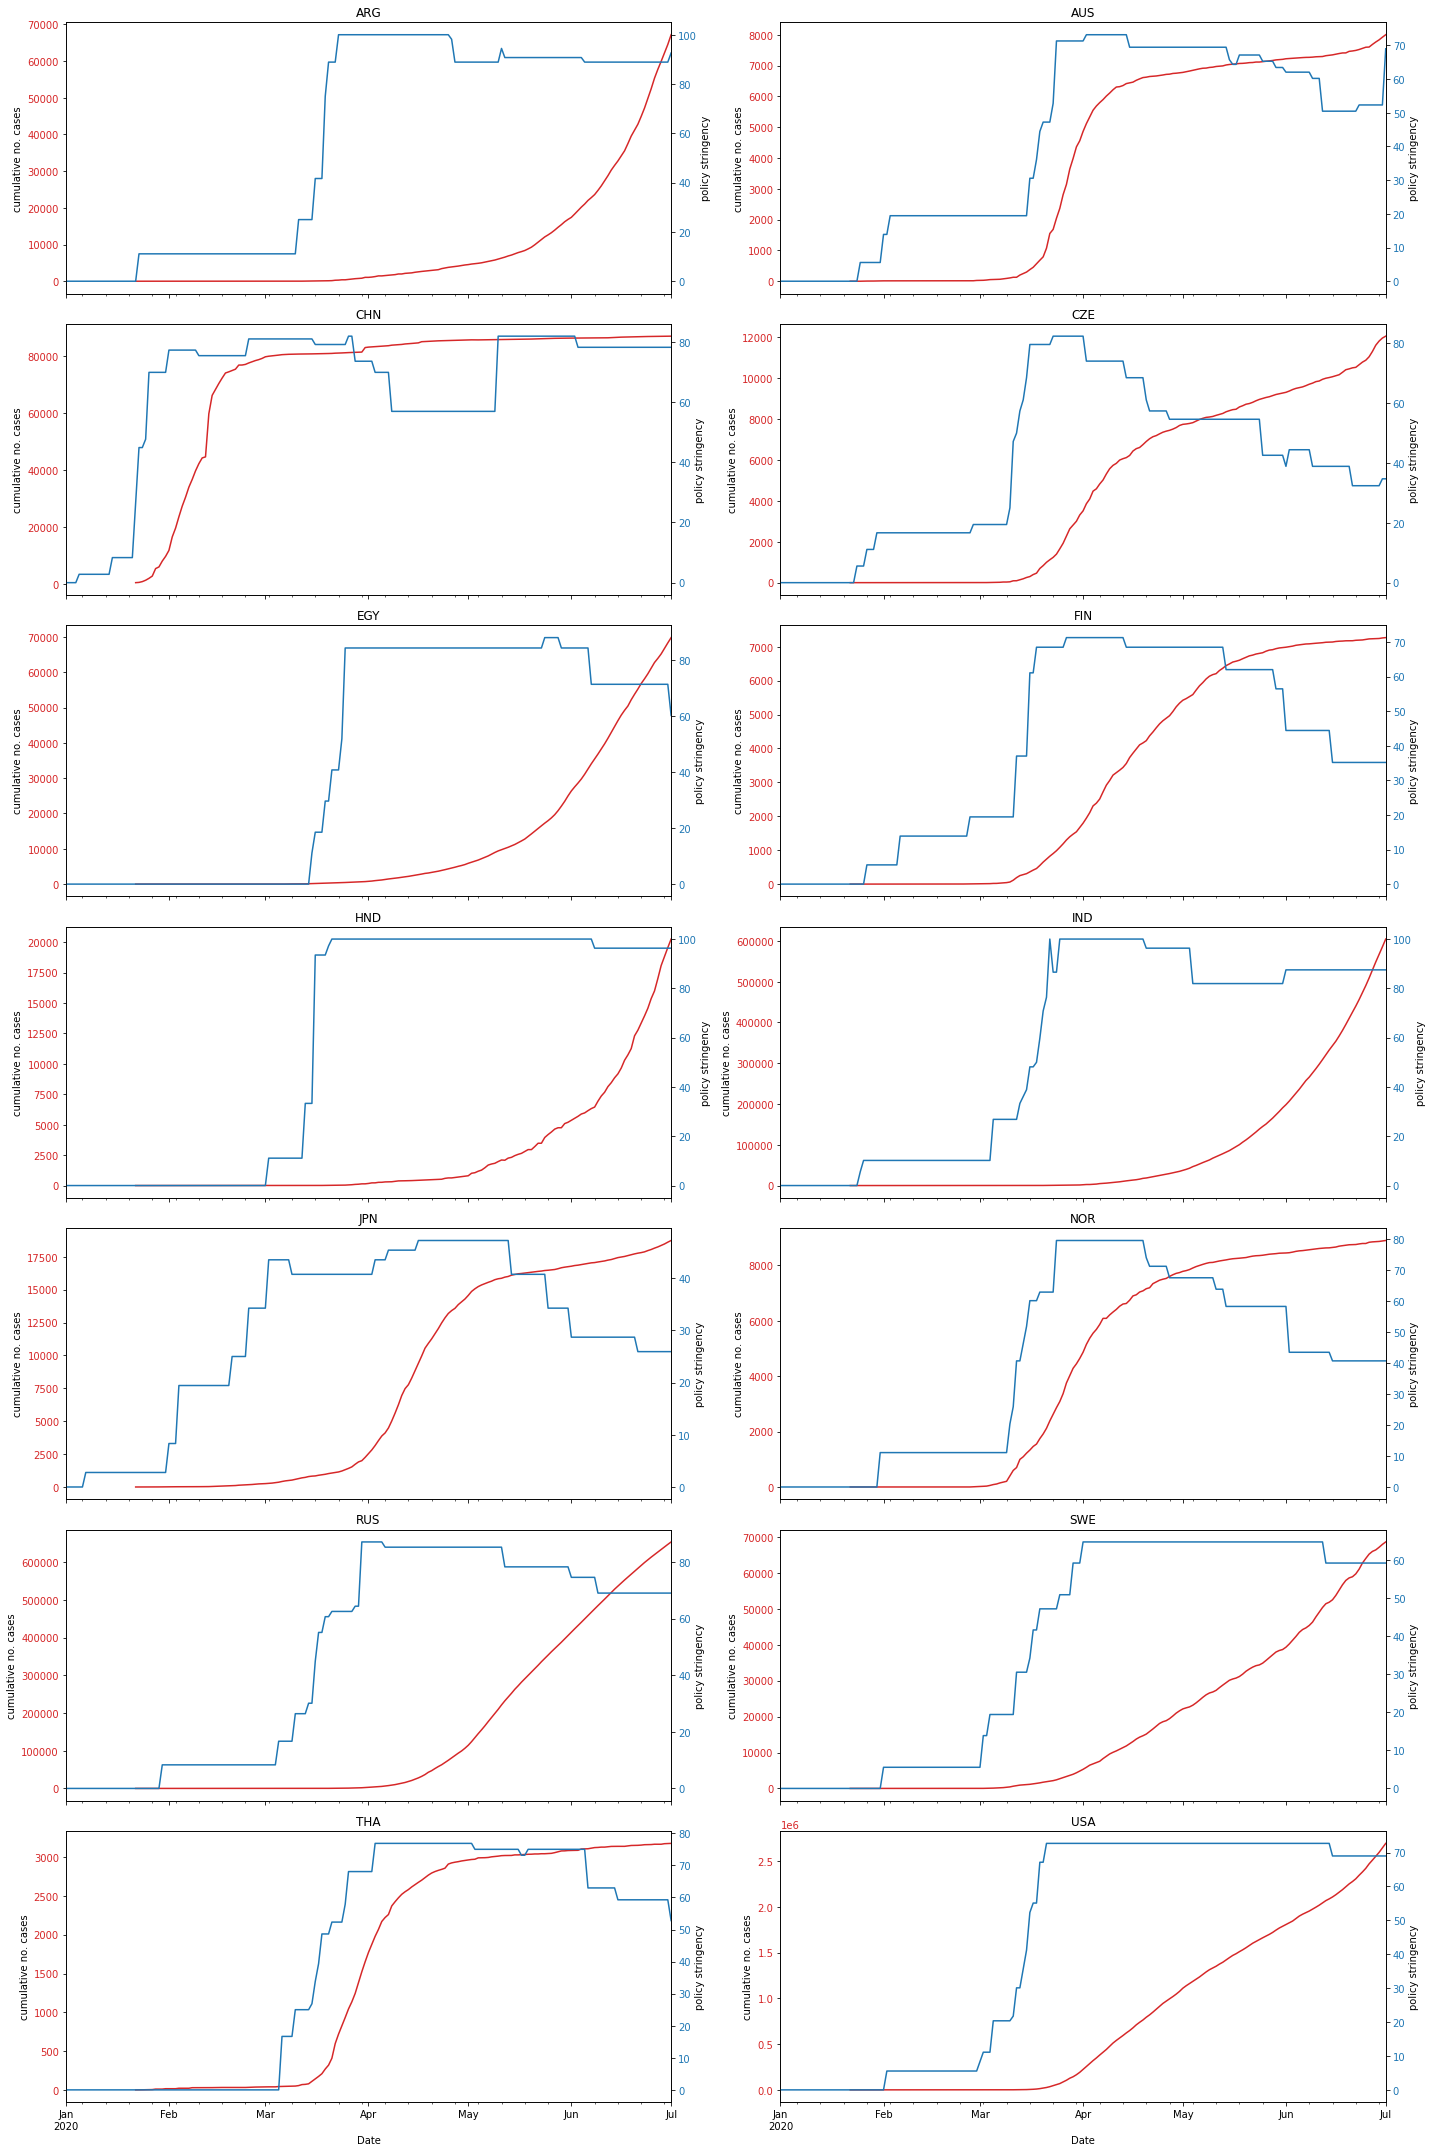

In [26]:
ncols = 2
nrows = len(ccs) // ncols
t0, t1 = '2020-01-01', '2020-07-01'

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(20, 30))
for i in range(nrows * ncols):
  ax1 = axs[i // ncols, i % ncols]
  
  col = 'tab:red'
  cases.loc[t0:t1, ccs[i]].plot(ax=ax1, color=col)
  ax1.tick_params(axis='y', labelcolor=col)
  ax1.set_ylabel('cumulative no. cases')
  ax1.set_title(ccs[i])

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  col = 'tab:blue'
  stringent.loc[t0:t1, ccs[i]].plot(ax=ax2, color=col)
  ax2.tick_params(axis='y', labelcolor=col)
  ax2.set_ylabel('policy stringency')
fig.tight_layout()

Implementation time of different (containment) policies.

In [27]:
for i in idch:
  print(i.replace('_', ' >> '))

C1 >> School closing
C2 >> Workplace closing
C3 >> Cancel public events
C4 >> Restrictions on gatherings
C5 >> Close public transport
C6 >> Stay at home requirements
C7 >> Restrictions on internal movement
C8 >> International travel controls
H1 >> Public information campaigns
H6 >> Facial Coverings


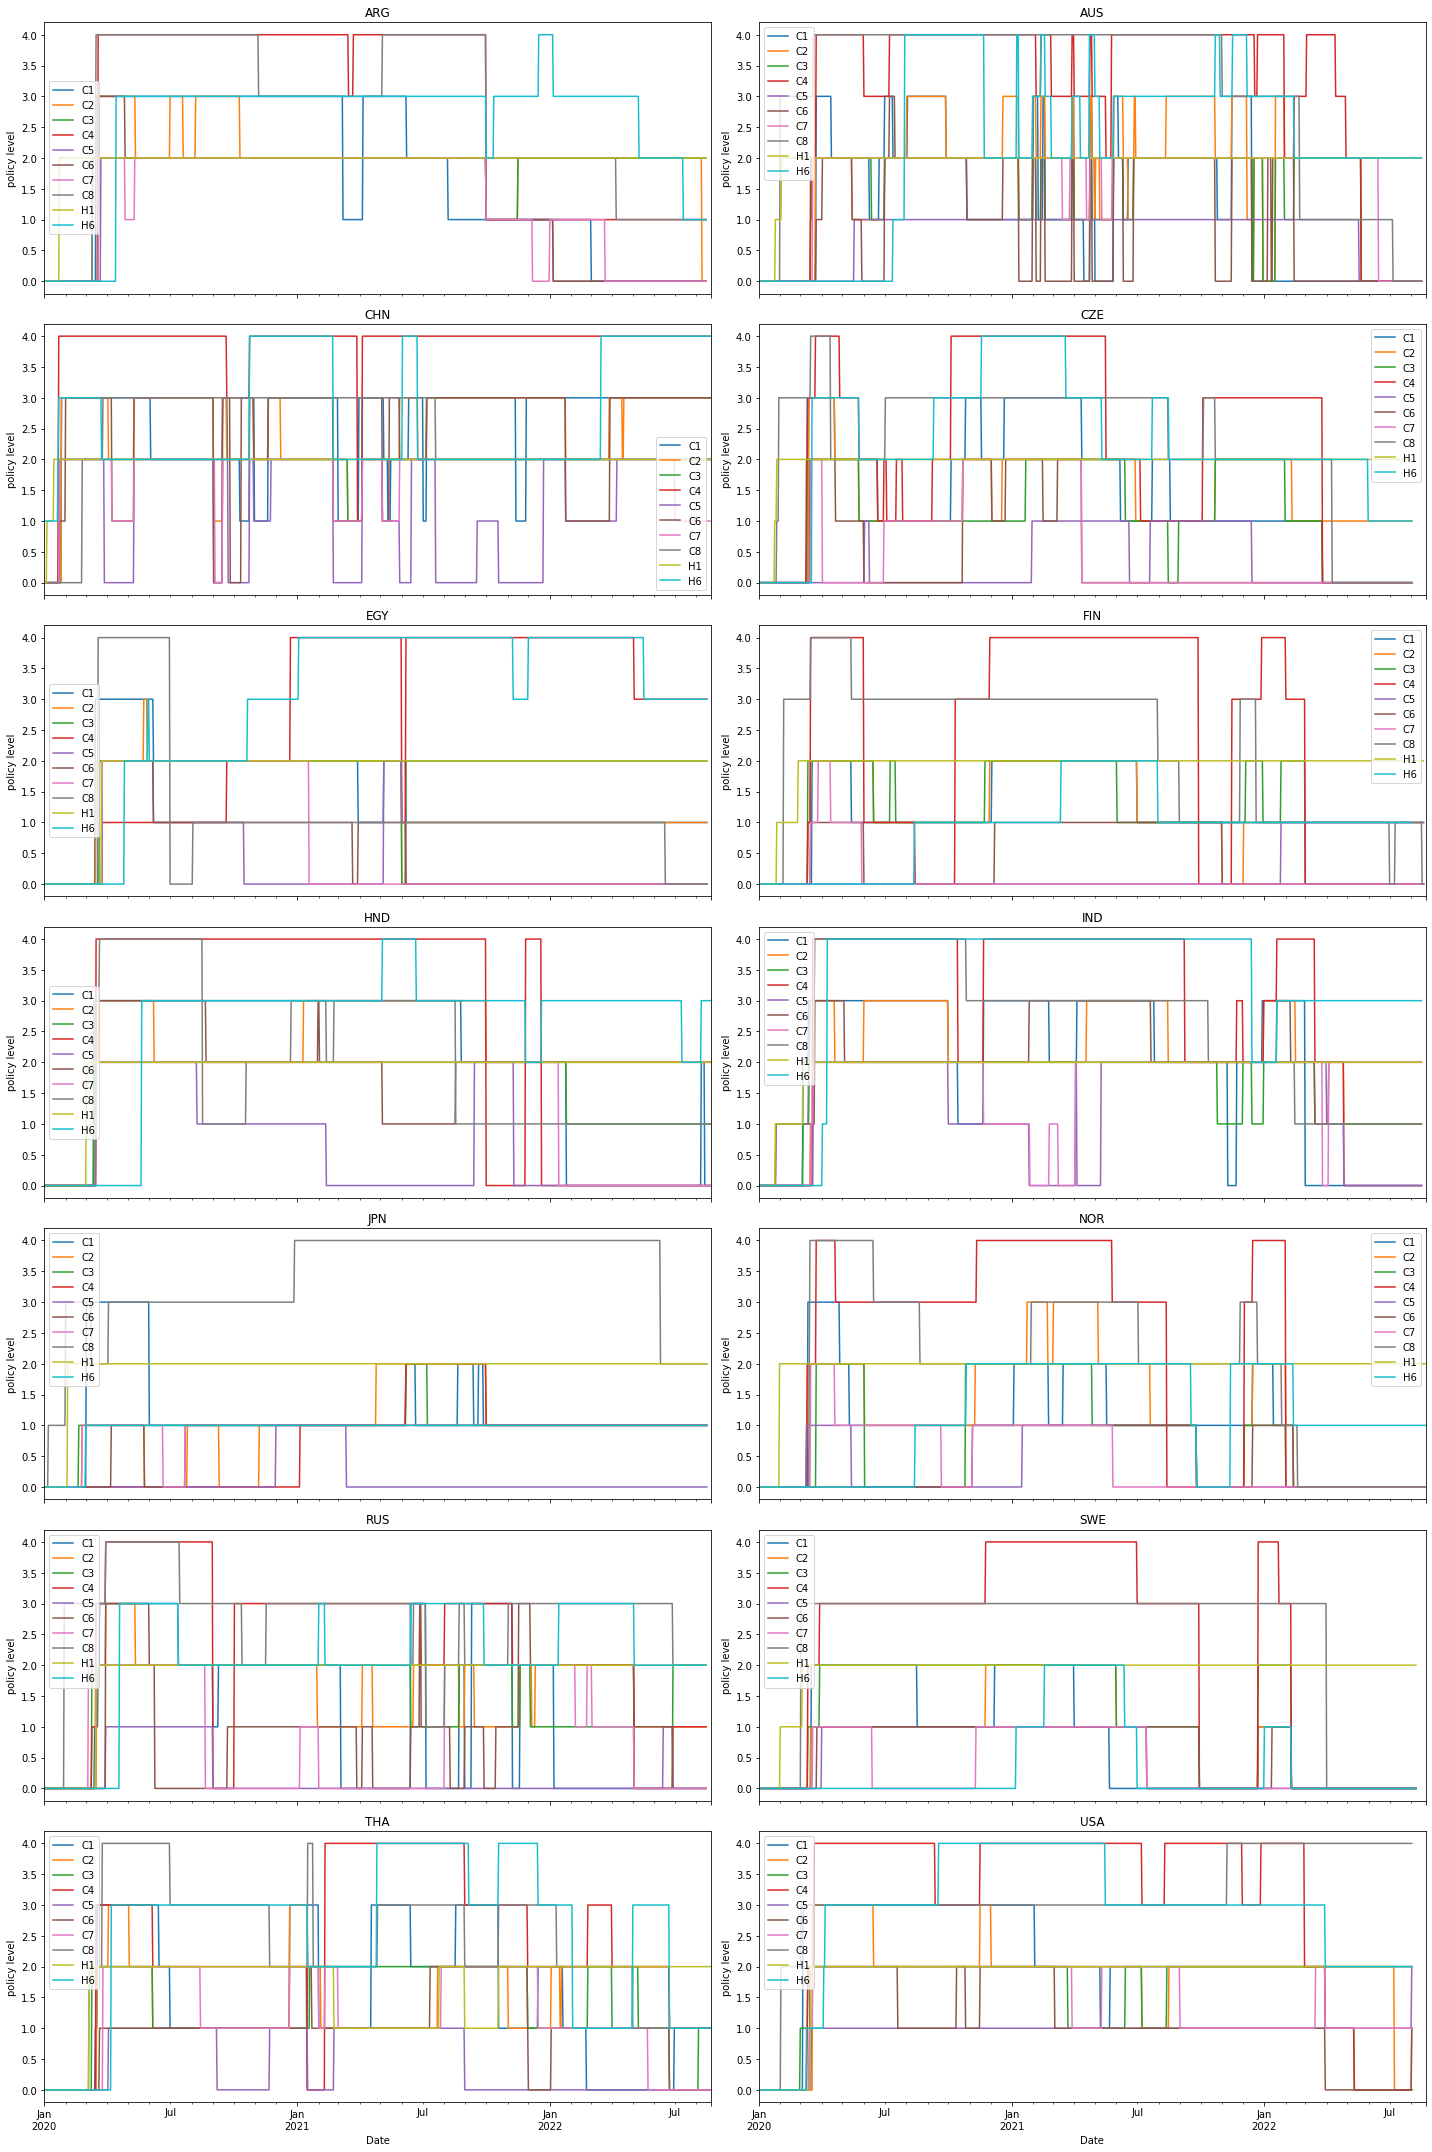

In [28]:
from img.plt import multiple_plot

policy_indicators = [C1, C2, C3, C4, C5, C6, C7, C8, H1, H6]
legend = [s.split('_')[0] for s in idch]

fig, axs = multiple_plot(ccs, policy_indicators, ylabel='policy level', legend=legend)
fig.tight_layout()

# Virus

Virus propagation data is obtained from the CSSE at Johns Hopkins University.

## Data

In [29]:
url_cases = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
url_death = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
url_recov = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

In [30]:
jhu_cases = pd.read_csv(url_cases)
jhu_cases.shape

(285, 947)

In [31]:
jhu_death = pd.read_csv(url_death)
jhu_death.shape

(289, 947)

In [32]:
jhu_recov = pd.read_csv(url_recov)
jhu_recov.shape

(270, 947)

### Area level reporting

Australia, Canada and China are reported at the province/state level. Dependencies of the Netherlands, the UK, France and Denmark are listed under the province/state level.

This is shown for the `cases` data set, but it happens in the three of them.

In [33]:
jhu_cases[jhu_cases['Country/Region'] == 'Australia']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/12/22,8/13/22,8/14/22,8/15/22,8/16/22,8/17/22,8/18/22,8/19/22,8/20/22,8/21/22
9,Australian Capital Territory,Australia,-35.4735,149.0124,0,0,0,0,0,0,...,197883,198193,198480,198866,199292,199673,199919,199919,200357,200570
10,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,3329963,3336902,3342373,3349487,3357506,3365632,3372497,3378587,3382897,3387881
11,Northern Territory,Australia,-12.4634,130.8456,0,0,0,0,0,0,...,93823,93934,94032,94032,94396,94396,94532,94730,94795,94893
12,Queensland,Australia,-27.4698,153.0251,0,0,0,0,0,0,...,1572252,1574198,1576102,1579334,1582419,1585477,1588222,1590875,1592023,1593614
13,South Australia,Australia,-34.9285,138.6007,0,0,0,0,0,0,...,735513,736959,739189,739234,740679,743393,744489,745386,746080,746910
14,Tasmania,Australia,-42.8821,147.3272,0,0,0,0,0,0,...,239977,240346,240744,241256,241732,242172,242568,242887,243094,243302
15,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,2506892,2510325,2513940,2518798,2523433,2527767,2531624,2534859,2537147,2539653
16,Western Australia,Australia,-31.9505,115.8605,0,0,0,0,0,0,...,1102537,1104096,1105636,1107738,1110117,1112078,1113823,1115426,1115426,1115426


In [34]:
jhu_cases[jhu_cases['Country/Region'] == 'Netherlands']

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,8/12/22,8/13/22,8/14/22,8/15/22,8/16/22,8/17/22,8/18/22,8/19/22,8/20/22,8/21/22
195,Aruba,Netherlands,12.5211,-69.9683,0,0,0,0,0,0,...,42478,42478,42478,42572,42572,42638,42638,42638,42638,42638
196,"Bonaire, Sint Eustatius and Saba",Netherlands,12.1784,-68.2385,0,0,0,0,0,0,...,10999,10999,10999,10999,10999,11091,11091,11091,11091,11091
197,Curacao,Netherlands,12.1696,-68.9900,0,0,0,0,0,0,...,45209,45209,45209,45209,45209,45243,45243,45243,45243,45243
198,Sint Maarten,Netherlands,18.0425,-63.0548,0,0,0,0,0,0,...,10791,10791,10791,10791,10809,10809,10809,10809,10809,10809
199,NaN,Netherlands,52.1326,5.2913,0,0,0,0,0,0,...,8362450,8362450,8362450,8366460,8368367,8370047,8370386,8372846,8372846,8372846


Canada does not have recovery data available at province-level.

In [35]:
jhu_cases['Country/Region'].value_counts().head(8)

China             34
Canada            16
United Kingdom    14
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Name: Country/Region, dtype: int64

In [36]:
jhu_death['Country/Region'].value_counts().head(8)

China             34
United Kingdom    18
Canada            16
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Name: Country/Region, dtype: int64

In [37]:
jhu_recov['Country/Region'].value_counts().head(8)

China             34
United Kingdom    14
France            12
Australia          8
Netherlands        5
Denmark            3
New Zealand        2
Portugal           1
Name: Country/Region, dtype: int64

Remove global registries from countries with subregional registies and the sum up these subregional cases.

In [38]:
sel_reg = ['Netherlands', 'United Kingdom', 'France', 'Denmark']

def remove_global_registry(jhu_df):
  'Remove global country records when local ones exist.'
  a = jhu_df['Country/Region'].isin(sel_reg)
  b = jhu_df['Province/State'].isna()
  cond = pd.DataFrame([a, b]).all()
  idx = jhu_df[cond].index
  jhu_df.drop(idx, axis=0, inplace=True)

# remove global Netherlands, UK, France and Denmark
remove_global_registry(jhu_cases)
remove_global_registry(jhu_death)
remove_global_registry(jhu_recov)
# drop subregion, latitude and longitude columns
jhu_cases.drop(jhu_cases.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_death.drop(jhu_death.columns[[0, 2, 3]], axis=1, inplace=True)
jhu_recov.drop(jhu_recov.columns[[0, 2, 3]], axis=1, inplace=True)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (281, 944)
deaths shape: (285, 944)
recoveries shape: (266, 944)


In [39]:
# reshape dfs
jhu_cases = jhu_cases.groupby('Country/Region').sum()
jhu_cases = jhu_cases.T # transpose columns / rows
jhu_cases.index = pd.to_datetime(jhu_cases.index)
jhu_death = jhu_death.groupby('Country/Region').sum()
jhu_death = jhu_death.T # transpose columns / rows
jhu_death.index = pd.to_datetime(jhu_death.index)
jhu_recov = jhu_recov.groupby('Country/Region').sum()
jhu_recov = jhu_recov.T # transpose columns / rows
jhu_recov.index = pd.to_datetime(jhu_recov.index)

print('cases shape:',      jhu_cases.shape)
print('deaths shape:',     jhu_death.shape)
print('recoveries shape:', jhu_recov.shape)

cases shape: (943, 199)
deaths shape: (943, 199)
recoveries shape: (943, 199)


### Compartment variables

To prepare data to input into models:

1. Restrict the country dictionary to a previously selected subset. Do the same with the population data-frame.
1. Create separate dataframes containing data on countries of interest only.
1. Apply a smoothing average to the curves.
1. Use them to compute further variables (compartments) needed to represent the compartmental model.

In [40]:
# reduce the size of the dictionary
cc_dict = {cc : cc_dict[cc] for cc in ccs}

In [41]:
pop_df = pop_df.loc[cc_dict.values(), '2021 Population']
pop_df = pop_df.convert_dtypes(int)
pop_dict = pop_df.to_dict()
pop_dict

{'Argentina': 45276780,
 'Australia': 25921089,
 'China': 1425893465,
 'Czech Republic': 10510751,
 'Egypt': 109262178,
 'Finland': 5535992,
 'Honduras': 10278345,
 'India': 1407563842,
 'Japan': 124612530,
 'Norway': 5403021,
 'Russia': 145102755,
 'Sweden': 10467097,
 'Thailand': 71601103,
 'United States': 336997624}

In [42]:
# diff value in diff df
cc_dict['USA'] = 'US'
cc_dict['CZE'] = 'Czechia'

In [43]:
window = 7

In [44]:
cum_cases = jhu_cases[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_cases

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000e+00,8.792500e+02,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.750000e+00,1.500000e+00
2020-01-23,0.000000e+00,8.000000e-01,1.118400e+03,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,2.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.400000e+00,2.200000e+00
2020-01-24,0.000000e+00,1.500000e+00,1.411500e+03,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,2.666667e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.833333e+00,2.666667e+00
2020-01-25,0.000000e+00,2.000000e+00,1.996857e+03,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,3.285714e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.857143e+00,2.788143e+03,0.000000e+00,0.0,1.428571e-01,0.000000,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.428571e+00,3.714286e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,9.633732e+06,9.865938e+06,2.364071e+06,4.019595e+06,515645.0,1.243952e+06,449143.000000,4.430188e+07,1.624641e+07,1.458578e+06,1.869546e+07,2.554973e+06,4.628092e+06,9.326004e+07
2022-08-18,9.637255e+06,9.881903e+06,2.372411e+06,4.021425e+06,515645.0,1.245603e+06,449575.571429,4.431339e+07,1.646521e+07,1.458706e+06,1.872859e+07,2.555966e+06,4.630038e+06,9.334329e+07
2022-08-19,9.637842e+06,9.890762e+06,2.376924e+06,4.022474e+06,515645.0,1.246704e+06,449944.000000,4.431934e+07,1.657689e+07,1.458775e+06,1.874466e+07,2.556627e+06,4.631112e+06,9.339171e+07
2022-08-20,9.638664e+06,9.899000e+06,2.381373e+06,4.023380e+06,515645.0,1.248245e+06,450033.800000,4.432595e+07,1.670001e+07,1.458838e+06,1.876246e+07,2.557554e+06,4.632123e+06,9.344201e+07


In [45]:
cum_deaths = jhu_death[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_deaths

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2020-01-23,0.000000,0.000000,31.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2020-01-24,0.000000,0.000000,40.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2020-01-25,0.000000,0.000000,53.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
2020-01-26,0.000000,0.000000,69.714286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,129566.000000,13133.000000,14815.714286,40685.857143,24785.285714,5400.142857,10958.857143,527197.285714,36000.428571,3874.0,375536.000000,19594.000000,31943.142857,1.038899e+06
2022-08-18,129577.428571,13202.000000,14821.428571,40697.142857,24786.000000,5416.857143,10960.428571,527240.000000,36266.285714,3882.0,375597.142857,19616.000000,31971.285714,1.039475e+06
2022-08-19,129579.333333,13243.333333,14824.833333,40703.333333,24786.000000,5428.000000,10961.500000,527263.666667,36410.333333,3890.0,375627.833333,19630.666667,31985.333333,1.039795e+06
2022-08-20,129582.000000,13287.200000,14827.400000,40709.200000,24786.000000,5443.600000,10962.200000,527289.600000,36550.800000,3890.0,375659.400000,19651.200000,31999.400000,1.040149e+06


In [46]:
cum_recoveries = jhu_recov[cc_dict.values()].rolling(window, min_periods=1, center=True).mean()
cum_recoveries

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.0,0.0,33.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2.500000,0.0
2020-01-23,0.0,0.0,36.400000,0.0,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,3.200000,0.0
2020-01-24,0.0,0.0,40.000000,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,3.666667,0.0
2020-01-25,0.0,0.0,48.714286,0.0,0.0,0.0,0.0,0.0,0.428571,0.0,0.0,0.0,4.000000,0.0
2020-01-26,0.0,0.0,61.857143,0.0,0.0,0.0,0.0,0.0,0.571429,0.0,0.0,0.0,4.571429,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2022-08-18,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2022-08-19,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2022-08-20,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [47]:
R = cum_deaths + cum_recoveries
R

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.500000,0.000000e+00
2020-01-23,0.000000,0.000000,68.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000,0.000000,3.200000,0.000000e+00
2020-01-24,0.000000,0.000000,80.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.0,0.000000,0.000000,3.666667,0.000000e+00
2020-01-25,0.000000,0.000000,101.857143,0.000000,0.000000,0.000000,0.000000,0.000000,0.428571,0.0,0.000000,0.000000,4.000000,0.000000e+00
2020-01-26,0.000000,0.000000,131.571429,0.000000,0.000000,0.000000,0.000000,0.000000,0.571429,0.0,0.000000,0.000000,4.571429,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,129566.000000,13133.000000,14815.714286,40685.857143,24785.285714,5400.142857,10958.857143,527197.285714,36000.428571,3874.0,375536.000000,19594.000000,31943.142857,1.038899e+06
2022-08-18,129577.428571,13202.000000,14821.428571,40697.142857,24786.000000,5416.857143,10960.428571,527240.000000,36266.285714,3882.0,375597.142857,19616.000000,31971.285714,1.039475e+06
2022-08-19,129579.333333,13243.333333,14824.833333,40703.333333,24786.000000,5428.000000,10961.500000,527263.666667,36410.333333,3890.0,375627.833333,19630.666667,31985.333333,1.039795e+06
2022-08-20,129582.000000,13287.200000,14827.400000,40709.200000,24786.000000,5443.600000,10962.200000,527289.600000,36550.800000,3890.0,375659.400000,19651.200000,31999.400000,1.040149e+06


In [48]:
I = cum_cases - R
I

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000e+00,0.000000e+00,8.202500e+02,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.250000e+00,1.500000e+00
2020-01-23,0.000000e+00,8.000000e-01,1.050200e+03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,2.200000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+00,2.200000e+00
2020-01-24,0.000000e+00,1.500000e+00,1.331333e+03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,2.333333e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.166667e+00,2.666667e+00
2020-01-25,0.000000e+00,2.000000e+00,1.895000e+03,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,2.857143e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.000000e+00
2020-01-26,0.000000e+00,2.857143e+00,2.656571e+03,0.000000e+00,0.000000,1.428571e-01,0.000000,0.000000e+00,3.428571e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.857143e+00,3.714286e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,9.504166e+06,9.852805e+06,2.349256e+06,3.978909e+06,490859.714286,1.238552e+06,438184.142857,4.377468e+07,1.621041e+07,1.454704e+06,1.831992e+07,2.535379e+06,4.596149e+06,9.222114e+07
2022-08-18,9.507677e+06,9.868701e+06,2.357589e+06,3.980728e+06,490859.000000,1.240186e+06,438615.142857,4.378615e+07,1.642894e+07,1.454824e+06,1.835299e+07,2.536350e+06,4.598067e+06,9.230382e+07
2022-08-19,9.508262e+06,9.877519e+06,2.362099e+06,3.981770e+06,490859.000000,1.241276e+06,438982.500000,4.379207e+07,1.654048e+07,1.454885e+06,1.836903e+07,2.536997e+06,4.599126e+06,9.235192e+07
2022-08-20,9.509082e+06,9.885713e+06,2.366546e+06,3.982671e+06,490859.000000,1.242802e+06,439071.600000,4.379866e+07,1.666346e+07,1.454948e+06,1.838680e+07,2.537902e+06,4.600123e+06,9.240186e+07


In [49]:
S = pop_dict.values() - cum_cases
S

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,4.527678e+07,2.592109e+07,1.425893e+09,1.051075e+07,109262178.0,5.535992e+06,1.027834e+07,1.407564e+09,1.246125e+08,5.403021e+06,1.451028e+08,1.046710e+07,7.160110e+07,3.369976e+08
2020-01-23,4.527678e+07,2.592109e+07,1.425892e+09,1.051075e+07,109262178.0,5.535992e+06,1.027834e+07,1.407564e+09,1.246125e+08,5.403021e+06,1.451028e+08,1.046710e+07,7.160110e+07,3.369976e+08
2020-01-24,4.527678e+07,2.592109e+07,1.425892e+09,1.051075e+07,109262178.0,5.535992e+06,1.027834e+07,1.407564e+09,1.246125e+08,5.403021e+06,1.451028e+08,1.046710e+07,7.160110e+07,3.369976e+08
2020-01-25,4.527678e+07,2.592109e+07,1.425891e+09,1.051075e+07,109262178.0,5.535992e+06,1.027834e+07,1.407564e+09,1.246125e+08,5.403021e+06,1.451028e+08,1.046710e+07,7.160110e+07,3.369976e+08
2020-01-26,4.527678e+07,2.592109e+07,1.425891e+09,1.051075e+07,109262178.0,5.535992e+06,1.027834e+07,1.407564e+09,1.246125e+08,5.403021e+06,1.451028e+08,1.046710e+07,7.160109e+07,3.369976e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,3.564305e+07,1.605515e+07,1.423529e+09,6.491156e+06,108746533.0,4.292040e+06,9.829202e+06,1.363262e+09,1.083661e+08,3.944443e+06,1.264073e+08,7.912124e+06,6.697301e+07,2.437376e+08
2022-08-18,3.563953e+07,1.603919e+07,1.423521e+09,6.489326e+06,108746533.0,4.290389e+06,9.828769e+06,1.363250e+09,1.081473e+08,3.944315e+06,1.263742e+08,7.911131e+06,6.697106e+07,2.436543e+08
2022-08-19,3.563894e+07,1.603033e+07,1.423517e+09,6.488277e+06,108746533.0,4.289288e+06,9.828401e+06,1.363245e+09,1.080356e+08,3.944246e+06,1.263581e+08,7.910470e+06,6.696999e+07,2.436059e+08
2022-08-20,3.563812e+07,1.602209e+07,1.423512e+09,6.487371e+06,108746533.0,4.287747e+06,9.828311e+06,1.363238e+09,1.079125e+08,3.944183e+06,1.263403e+08,7.909543e+06,6.696898e+07,2.435556e+08


Proportional compartments.

In [50]:
r_prop = R / pop_dict.values()
i_prop = I / pop_dict.values()
s_prop = S / pop_dict.values()

In [51]:
r_prop.agg(['min', 'max'])

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.000000,4.137757e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,3.491566e-08,0.000000
max,0.103518,0.000966,7.293202e-05,0.158974,0.002263,0.008491,0.010588,0.022225,0.006857,0.003479,0.039367,0.00188,4.471055e-04,0.018701


In [52]:
i_prop.agg(['min', 'max'])

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.000000,0.00000,5.752534e-07,0.000000,0.000000,0.000000,0.000000,0.000000,1.604975e-08,0.000000,0.000000,0.000000,3.026024e-08,4.451070e-09
max,0.210048,0.38165,1.662831e-03,0.378986,0.004494,0.224908,0.042731,0.031121,1.347391e-01,0.269295,0.126843,0.242595,6.426004e-02,2.743121e-01


In [53]:
s_prop.agg(['min', 'max'])

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
min,0.78709,0.617836,0.998327,0.617141,0.995281,0.774104,0.956202,0.968504,0.864967,0.729985,0.870568,0.755525,0.935293,0.722601
max,1.00000,1.000000,0.999999,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Labels

### Initial approximation

Operate with the proportional compartments; $s, i, r$. Analyse the beginning of the pandemic, assuming $\lim_{t\rightarrow0}s\rightarrow1$. Therefore, study the change of the growth rate $gr=\log{i_2}-\log{i_1}=\beta-\gamma$.

In [54]:
# handle log(0)
warnings.filterwarnings('ignore', category=RuntimeWarning)
log_i = np.log(i_prop)
warnings.resetwarnings()
# before the pandemic begins, the growth must be zero
log_i[np.isinf(log_i)] = 0
log_i

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,0.000000,0.000000,-14.368455,0.000000,0.000000,0.000000,0.000000,0.000000,-17.947573,0.000000,0.000000,0.000000,-17.275691,-19.230121
2020-01-23,0.000000,-17.293711,-14.121329,0.000000,0.000000,0.000000,0.000000,0.000000,-17.852262,0.000000,0.000000,0.000000,-17.298164,-18.847129
2020-01-24,0.000000,-16.665102,-13.884128,0.000000,0.000000,0.000000,0.000000,0.000000,-17.793422,0.000000,0.000000,0.000000,-17.313431,-18.654757
2020-01-25,0.000000,-16.377420,-13.531090,0.000000,0.000000,0.000000,0.000000,0.000000,-17.590898,0.000000,0.000000,0.000000,-16.988009,-18.536974
2020-01-26,0.000000,-16.020745,-13.193273,0.000000,0.000000,-17.472691,0.000000,0.000000,-17.408576,0.000000,0.000000,0.000000,-16.736694,-18.323400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,-1.561064,-0.967301,-6.408455,-0.971391,-5.405347,-1.497328,-3.155155,-3.470560,-2.039555,-1.312156,-2.069453,-1.417893,-2.745892,-1.295887
2022-08-18,-1.560695,-0.965689,-6.404914,-0.970934,-5.405349,-1.496009,-3.154172,-3.470298,-2.026164,-1.312074,-2.067649,-1.417511,-2.745475,-1.294990
2022-08-19,-1.560633,-0.964796,-6.403003,-0.970672,-5.405349,-1.495131,-3.153335,-3.470163,-2.019399,-1.312031,-2.066776,-1.417256,-2.745244,-1.294469
2022-08-20,-1.560547,-0.963966,-6.401122,-0.970446,-5.405349,-1.493903,-3.153132,-3.470012,-2.011991,-1.311988,-2.065809,-1.416899,-2.745027,-1.293929


In [55]:
gr = log_i[1:] - log_i[:-1].values # different index
gr

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,-17.293711,0.247127,0.000000,0.000000,0.000000,0.000000,0.000000,0.095310,0.000000,0.000000,0.000000,-0.022473,0.382992
2020-01-24,0.000000,0.628609,0.237200,0.000000,0.000000,0.000000,0.000000,0.000000,0.058841,0.000000,0.000000,0.000000,-0.015267,0.192372
2020-01-25,0.000000,0.287682,0.353038,0.000000,0.000000,0.000000,0.000000,0.000000,0.202524,0.000000,0.000000,0.000000,0.325422,0.117783
2020-01-26,0.000000,0.356675,0.337818,0.000000,0.000000,-17.472691,0.000000,0.000000,0.182322,0.000000,0.000000,0.000000,0.251314,0.213574
2020-01-27,0.000000,0.300105,0.328822,0.000000,0.000000,0.693147,0.000000,-23.011036,0.287682,0.000000,0.000000,0.000000,0.169899,0.175891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,0.000467,0.001689,0.003667,0.000460,-0.000001,0.001321,0.000984,0.000280,0.013146,0.000082,0.001725,0.000383,0.000421,0.000898
2022-08-18,0.000369,0.001612,0.003541,0.000457,-0.000001,0.001319,0.000983,0.000262,0.013391,0.000082,0.001804,0.000383,0.000417,0.000896
2022-08-19,0.000062,0.000893,0.001911,0.000262,0.000000,0.000878,0.000837,0.000135,0.006766,0.000042,0.000874,0.000255,0.000230,0.000521
2022-08-20,0.000086,0.000829,0.001881,0.000226,0.000000,0.001228,0.000203,0.000150,0.007408,0.000043,0.000967,0.000357,0.000217,0.000541


### Transmission coefficient computation

Operate with the relative compartments to save operations. Only assuming independence with time (same as last time), study $\beta=\frac{gr+\gamma}{s}=\frac{(\log{i_2}-\log{i_1})+\gamma}{s}$.

Because the SIR model (instead of the SEIR model) is being used, the resulting transmission coefficient will be small.

In [56]:
dr_dt = r_prop[1:] - r_prop[:-1].values # different index
dr_dt

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000e+00,0.000000e+00,6.452095e-09,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.604975e-09,0.000000,0.000000e+00,0.000000,9.776386e-09,0.000000e+00
2020-01-24,0.000000e+00,0.000000e+00,8.392399e-09,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.069983e-09,0.000000,0.000000e+00,0.000000,6.517590e-09,0.000000e+00
2020-01-25,0.000000e+00,0.000000e+00,1.521185e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.642738e-10,0.000000,0.000000e+00,0.000000,4.655422e-09,0.000000e+00
2020-01-26,0.000000e+00,0.000000e+00,2.083906e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.146411e-09,0.000000,0.000000e+00,0.000000,7.980723e-09,0.000000e+00
2020-01-27,0.000000e+00,1.102246e-08,2.584845e-08,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.146411e-09,0.000000,0.000000e+00,0.000000,9.975904e-09,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,3.975548e-07,2.744594e-06,4.007512e-09,1.060139e-06,6.537356e-09,0.000003,1.528873e-07,2.994028e-08,2.049782e-06,0.000001,4.125156e-07,0.000002,3.970410e-07,1.382799e-06
2022-08-18,2.524157e-07,2.661925e-06,4.007512e-09,1.073731e-06,6.537356e-09,0.000003,1.528873e-07,3.034625e-08,2.133470e-06,0.000001,4.213763e-07,0.000002,3.930506e-07,1.707515e-06
2022-08-19,4.206929e-08,1.594583e-06,2.387809e-09,5.889661e-07,0.000000e+00,0.000002,1.042414e-07,1.681392e-08,1.155964e-06,0.000001,2.115086e-07,0.000001,1.961928e-07,9.498442e-07
2022-08-20,5.889700e-08,1.692316e-06,1.800041e-09,5.581587e-07,0.000000e+00,0.000003,6.810435e-08,1.842427e-08,1.127227e-06,0.000000,2.175470e-07,0.000002,1.964588e-07,1.051442e-06


In [57]:
gamma = dr_dt / i_prop[1:]
gamma[np.isinf(gamma)] = np.nan # division by zero
gamma[gamma.isna()] = 0         # before the pandemic begins
gamma

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000e+00,0.000000,0.008760,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.090909,0.000000,0.000000,0.000000,0.318182,0.000000
2020-01-24,0.000000e+00,0.000000,0.008988,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.057143,0.000000,0.000000,0.000000,0.215385,0.000000
2020-01-25,0.000000e+00,0.000000,0.011446,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.033333,0.000000,0.000000,0.000000,0.111111,0.000000
2020-01-26,0.000000e+00,0.000000,0.011185,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.041667,0.000000,0.000000,0.000000,0.148148,0.000000
2020-01-27,0.000000e+00,0.074074,0.009986,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.031250,0.000000,0.000000,0.000000,0.156250,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,1.893906e-06,0.000007,0.000002,0.000003,0.000001,0.000013,0.000004,9.627222e-07,0.000016,0.000005,0.000003,0.000009,0.000006,0.000005
2022-08-18,1.202036e-06,0.000007,0.000002,0.000003,0.000001,0.000013,0.000004,9.755205e-07,0.000016,0.000005,0.000003,0.000009,0.000006,0.000006
2022-08-19,2.003270e-07,0.000004,0.000001,0.000002,0.000000,0.000009,0.000002,5.404327e-07,0.000009,0.000005,0.000002,0.000006,0.000003,0.000003
2022-08-20,2.804337e-07,0.000004,0.000001,0.000001,0.000000,0.000013,0.000002,5.921033e-07,0.000008,0.000000,0.000002,0.000008,0.000003,0.000004


In [58]:
beta = (gr + gamma) / s_prop[1:]
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-23,0.000000,-17.293712,0.255887,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.186219,0.000000,0.000000,0.000000,0.295709,0.382992
2020-01-24,0.000000,0.628609,0.246189,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.115983,0.000000,0.000000,0.000000,0.200117,0.192372
2020-01-25,0.000000,0.287682,0.364485,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.235858,0.000000,0.000000,0.000000,0.436534,0.117783
2020-01-26,0.000000,0.356675,0.349003,0.000000,0.000000e+00,-17.472692,0.000000,0.000000,0.223988,0.000000,0.000000,0.000000,0.399463,0.213574
2020-01-27,0.000000,0.374179,0.338809,0.000000,0.000000e+00,0.693147,0.000000,-23.011036,0.318932,0.000000,0.000000,0.000000,0.326149,0.175891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,0.000596,0.002738,0.003675,0.000749,1.064282e-12,0.001721,0.001033,0.000290,0.015135,0.000120,0.001984,0.000518,0.000457,0.001248
2022-08-18,0.000471,0.002616,0.003549,0.000745,1.063504e-12,0.001719,0.001032,0.000271,0.015448,0.000120,0.002075,0.000518,0.000453,0.001248
2022-08-19,0.000078,0.001451,0.001916,0.000427,0.000000e+00,0.001145,0.000878,0.000140,0.007814,0.000065,0.001005,0.000345,0.000250,0.000725
2022-08-20,0.000110,0.001349,0.001885,0.000369,0.000000e+00,0.001602,0.000214,0.000156,0.008564,0.000059,0.001112,0.000483,0.000235,0.000753


An alternative path to the transmission rate is $\beta=\frac{\log{s_1}-\log{s_2}}{i}$. This has the advantage of not having to deal with values $\log0$, which we were classifying as $0$.
 
Furthermore, if the _total_ compartmental variables are used, even highly negative logarithms are avoided.
As a result, there won't be intial spikes (as seen later).

$$\beta=\frac{\log{S_1}-\log{S_2}}{I}$$


In [59]:
# the alternative formula
log_s = np.log(S)
diff_log = log_s[:-1].values - log_s[1:] # same index as other variables
beta = diff_log / I
beta

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,3.857862e-08,1.597025e-10,NaN,NaN,NaN,NaN,NaN,1.459069e-09,NaN,NaN,NaN,4.126396e-09,9.441676e-10
2020-01-24,NaN,1.800336e-08,1.543982e-10,NaN,NaN,NaN,NaN,NaN,9.171285e-10,NaN,NaN,NaN,2.793253e-09,5.192913e-10
2020-01-25,NaN,9.644657e-09,2.166333e-10,NaN,NaN,NaN,NaN,NaN,1.738722e-09,NaN,NaN,NaN,5.431326e-09,3.297084e-10
2020-01-26,NaN,1.157359e-08,2.088938e-10,NaN,NaN,1.806361e-07,NaN,NaN,1.671849e-09,NaN,NaN,NaN,5.172692e-09,5.706507e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,1.315566e-11,1.054849e-10,2.572736e-12,7.128096e-11,0.0,3.105709e-10,1.004323e-10,2.057877e-13,1.205485e-10,2.228218e-11,1.365921e-11,4.946933e-11,6.383550e-12,3.702457e-12
2022-08-18,1.039560e-11,1.008098e-10,2.484866e-12,7.082619e-11,0.0,3.102809e-10,1.003380e-10,1.928455e-13,1.230208e-10,2.228107e-11,1.428468e-11,4.945660e-11,6.319838e-12,3.701122e-12
2022-08-19,1.732593e-12,5.593758e-11,1.342152e-12,4.060542e-11,0.0,2.067386e-10,8.539159e-11,9.960651e-14,6.246258e-11,1.204485e-11,6.923534e-12,3.296611e-11,3.485864e-12,2.151994e-12
2022-08-20,2.425470e-12,5.199525e-11,1.320812e-12,3.506991e-11,0.0,2.891679e-10,2.080943e-11,1.108062e-13,6.843382e-11,1.097243e-11,7.662716e-12,4.614071e-11,3.281528e-12,2.234693e-12


Smooth $\beta$ over a period of time computing the rolling average.

In [60]:
beta_smooth_10 = beta.rolling(10, min_periods=1).mean()
beta_smooth_20 = beta.rolling(20, min_periods=1).mean()
beta_smooth_30 = beta.rolling(30, min_periods=1).mean()

Alternate between different constant values of $\beta$ in different time periods. Use the average value in each time range.

In [61]:
beta_rs = beta.resample('1M', label='left').mean()
beta_cst = beta_rs.resample('1d').ffill()
beta_cst

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2019-12-31,NaN,1.360842e-08,1.805251e-10,NaN,NaN,7.375974e-08,NaN,3.706154e-10,1.758986e-09,NaN,3.589411e-09,5.838402e-08,3.935689e-09,4.748436e-10
2020-01-01,NaN,1.360842e-08,1.805251e-10,NaN,NaN,7.375974e-08,NaN,3.706154e-10,1.758986e-09,NaN,3.589411e-09,5.838402e-08,3.935689e-09,4.748436e-10
2020-01-02,NaN,1.360842e-08,1.805251e-10,NaN,NaN,7.375974e-08,NaN,3.706154e-10,1.758986e-09,NaN,3.589411e-09,5.838402e-08,3.935689e-09,4.748436e-10
2020-01-03,NaN,1.360842e-08,1.805251e-10,NaN,NaN,7.375974e-08,NaN,3.706154e-10,1.758986e-09,NaN,3.589411e-09,5.838402e-08,3.935689e-09,4.748436e-10
2020-01-04,NaN,1.360842e-08,1.805251e-10,NaN,NaN,7.375974e-08,NaN,3.706154e-10,1.758986e-09,NaN,3.589411e-09,5.838402e-08,3.935689e-09,4.748436e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-27,1.608840e-11,2.747746e-10,1.301165e-12,6.678437e-11,0.0,1.954995e-10,1.002997e-10,3.094349e-13,8.880935e-11,5.027374e-11,2.394951e-12,3.559619e-11,7.394896e-12,5.653803e-12
2022-07-28,1.608840e-11,2.747746e-10,1.301165e-12,6.678437e-11,0.0,1.954995e-10,1.002997e-10,3.094349e-13,8.880935e-11,5.027374e-11,2.394951e-12,3.559619e-11,7.394896e-12,5.653803e-12
2022-07-29,1.608840e-11,2.747746e-10,1.301165e-12,6.678437e-11,0.0,1.954995e-10,1.002997e-10,3.094349e-13,8.880935e-11,5.027374e-11,2.394951e-12,3.559619e-11,7.394896e-12,5.653803e-12
2022-07-30,1.608840e-11,2.747746e-10,1.301165e-12,6.678437e-11,0.0,1.954995e-10,1.002997e-10,3.094349e-13,8.880935e-11,5.027374e-11,2.394951e-12,3.559619e-11,7.394896e-12,5.653803e-12


Restrict $\beta$ to *being smooth* between time intervals, plus some continuity constraints in the derivatives in between intervals (_knots_): cubic (degree 3) regression splines.

In [62]:
beta_spl = beta.copy()

for cn in cc_dict.values():
  x = range(beta.shape[0])
  y = beta_rs[cn]
  y[y.isna()] = 0
  knots = np.asarray(range(len(y))) * 30
  
  spl = splrep(knots, y)       # representation
  beta_spl[cn] = splev(x, spl) # evaluation

beta_spl

Country/Region,Argentina,Australia,China,Czechia,Egypt,Finland,Honduras,India,Japan,Norway,Russia,Sweden,Thailand,US
2020-01-22,-1.154240e-25,1.360842e-08,1.805251e-10,1.144622e-24,1.482878e-26,7.375974e-08,9.618668e-27,3.706154e-10,1.758986e-09,-5.739139e-25,3.589411e-09,5.838402e-08,3.935689e-09,4.748436e-10
2020-01-23,2.068577e-09,1.250650e-08,1.743577e-10,5.463190e-09,5.026359e-11,6.913761e-08,-1.660003e-09,3.482965e-10,1.713757e-09,9.721952e-09,3.361691e-09,5.477438e-08,3.638532e-09,4.176132e-10
2020-01-24,4.022015e-09,1.146884e-08,1.683274e-10,1.063555e-08,1.011851e-10,6.475465e-08,-3.164996e-09,3.270916e-10,1.669871e-09,1.891517e-08,3.145995e-09,5.133661e-08,3.358510e-09,3.647577e-10
2020-01-25,5.862806e-09,1.049385e-08,1.624331e-10,1.552313e-08,1.527016e-10,6.060531e-08,-4.519321e-09,3.069756e-10,1.627307e-09,2.759086e-08,2.942047e-09,4.806690e-08,3.095210e-09,3.161598e-10
2020-01-26,7.593441e-09,9.579962e-09,1.566737e-10,2.013199e-08,2.047498e-10,5.668405e-08,-5.727320e-09,2.879236e-10,1.586045e-09,3.576020e-08,2.749571e-09,4.496148e-08,2.848213e-09,2.717020e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-17,1.178173e-11,-1.443229e-11,1.765336e-12,4.913769e-11,4.865806e-13,1.059423e-09,7.121029e-11,1.552514e-13,9.538021e-11,3.590711e-11,1.308826e-11,4.258356e-11,5.556918e-12,3.165405e-12
2022-08-18,1.135950e-11,-3.879106e-11,1.751228e-12,4.581019e-11,5.700704e-13,1.108420e-09,6.470673e-11,1.423983e-13,9.098437e-11,3.811917e-11,1.362908e-11,4.195070e-11,5.441973e-12,2.988188e-12
2022-08-19,1.091484e-11,-6.433483e-11,1.735278e-12,4.228682e-11,6.590682e-13,1.159097e-09,5.779859e-11,1.289782e-13,8.625731e-11,4.053170e-11,1.418667e-11,4.125982e-11,5.322065e-12,2.803372e-12
2022-08-20,1.044725e-11,-9.108802e-11,1.717448e-12,3.856391e-11,7.537151e-13,1.211479e-09,5.047761e-11,1.149824e-13,8.119176e-11,4.314978e-11,1.476127e-11,4.050970e-11,5.197078e-12,2.610817e-12


## Visualization

In [63]:
cc_idx = 0
country = list(cc_dict.values())[cc_idx]

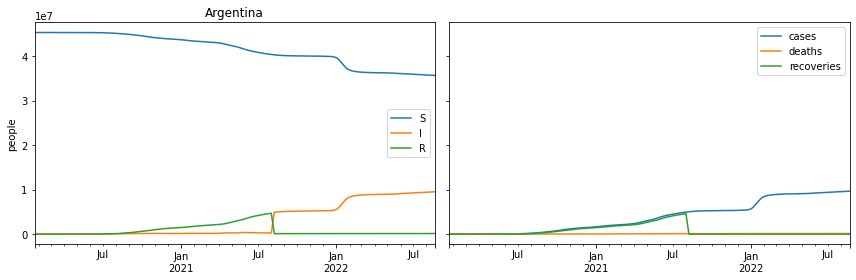

In [64]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,4))
S[country].plot(ax=axs[0], label='S')
I[country].plot(ax=axs[0], label='I')
R[country].plot(ax=axs[0], label='R')
axs[0].set(ylabel="people", title=country)
axs[0].legend()
cum_cases[country].plot(ax=axs[1], label="cases")
cum_deaths[country].plot(ax=axs[1], label="deaths")
cum_recoveries[country].plot(ax=axs[1], label="recoveries")
axs[1].legend()
fig.tight_layout()

Extreme spikes appear due to the use of logarithm among with proportional compartments (starting values $\approx 0$).

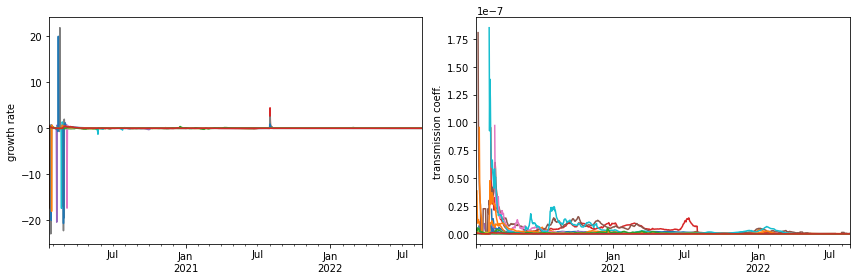

In [65]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
gr.plot(legend=False, ax=axs[0])
beta.plot(legend=False, ax=axs[1])
axs[0].set_ylabel('growth rate')
axs[1].set_ylabel('transmission coeff.')
fig.tight_layout()

Most countries present additional spikes at the beginning of the pandemic. Possibly due to reporting concentrations. Furthermore, low population countries present various spikes.

Data for each country is considered after the first 25 cases to avoid the initial spikes.

In [66]:
xa = []
for cname in cc_dict.values():
    xa.append(cum_cases[cname][cum_cases[cname] > 25].index.min())

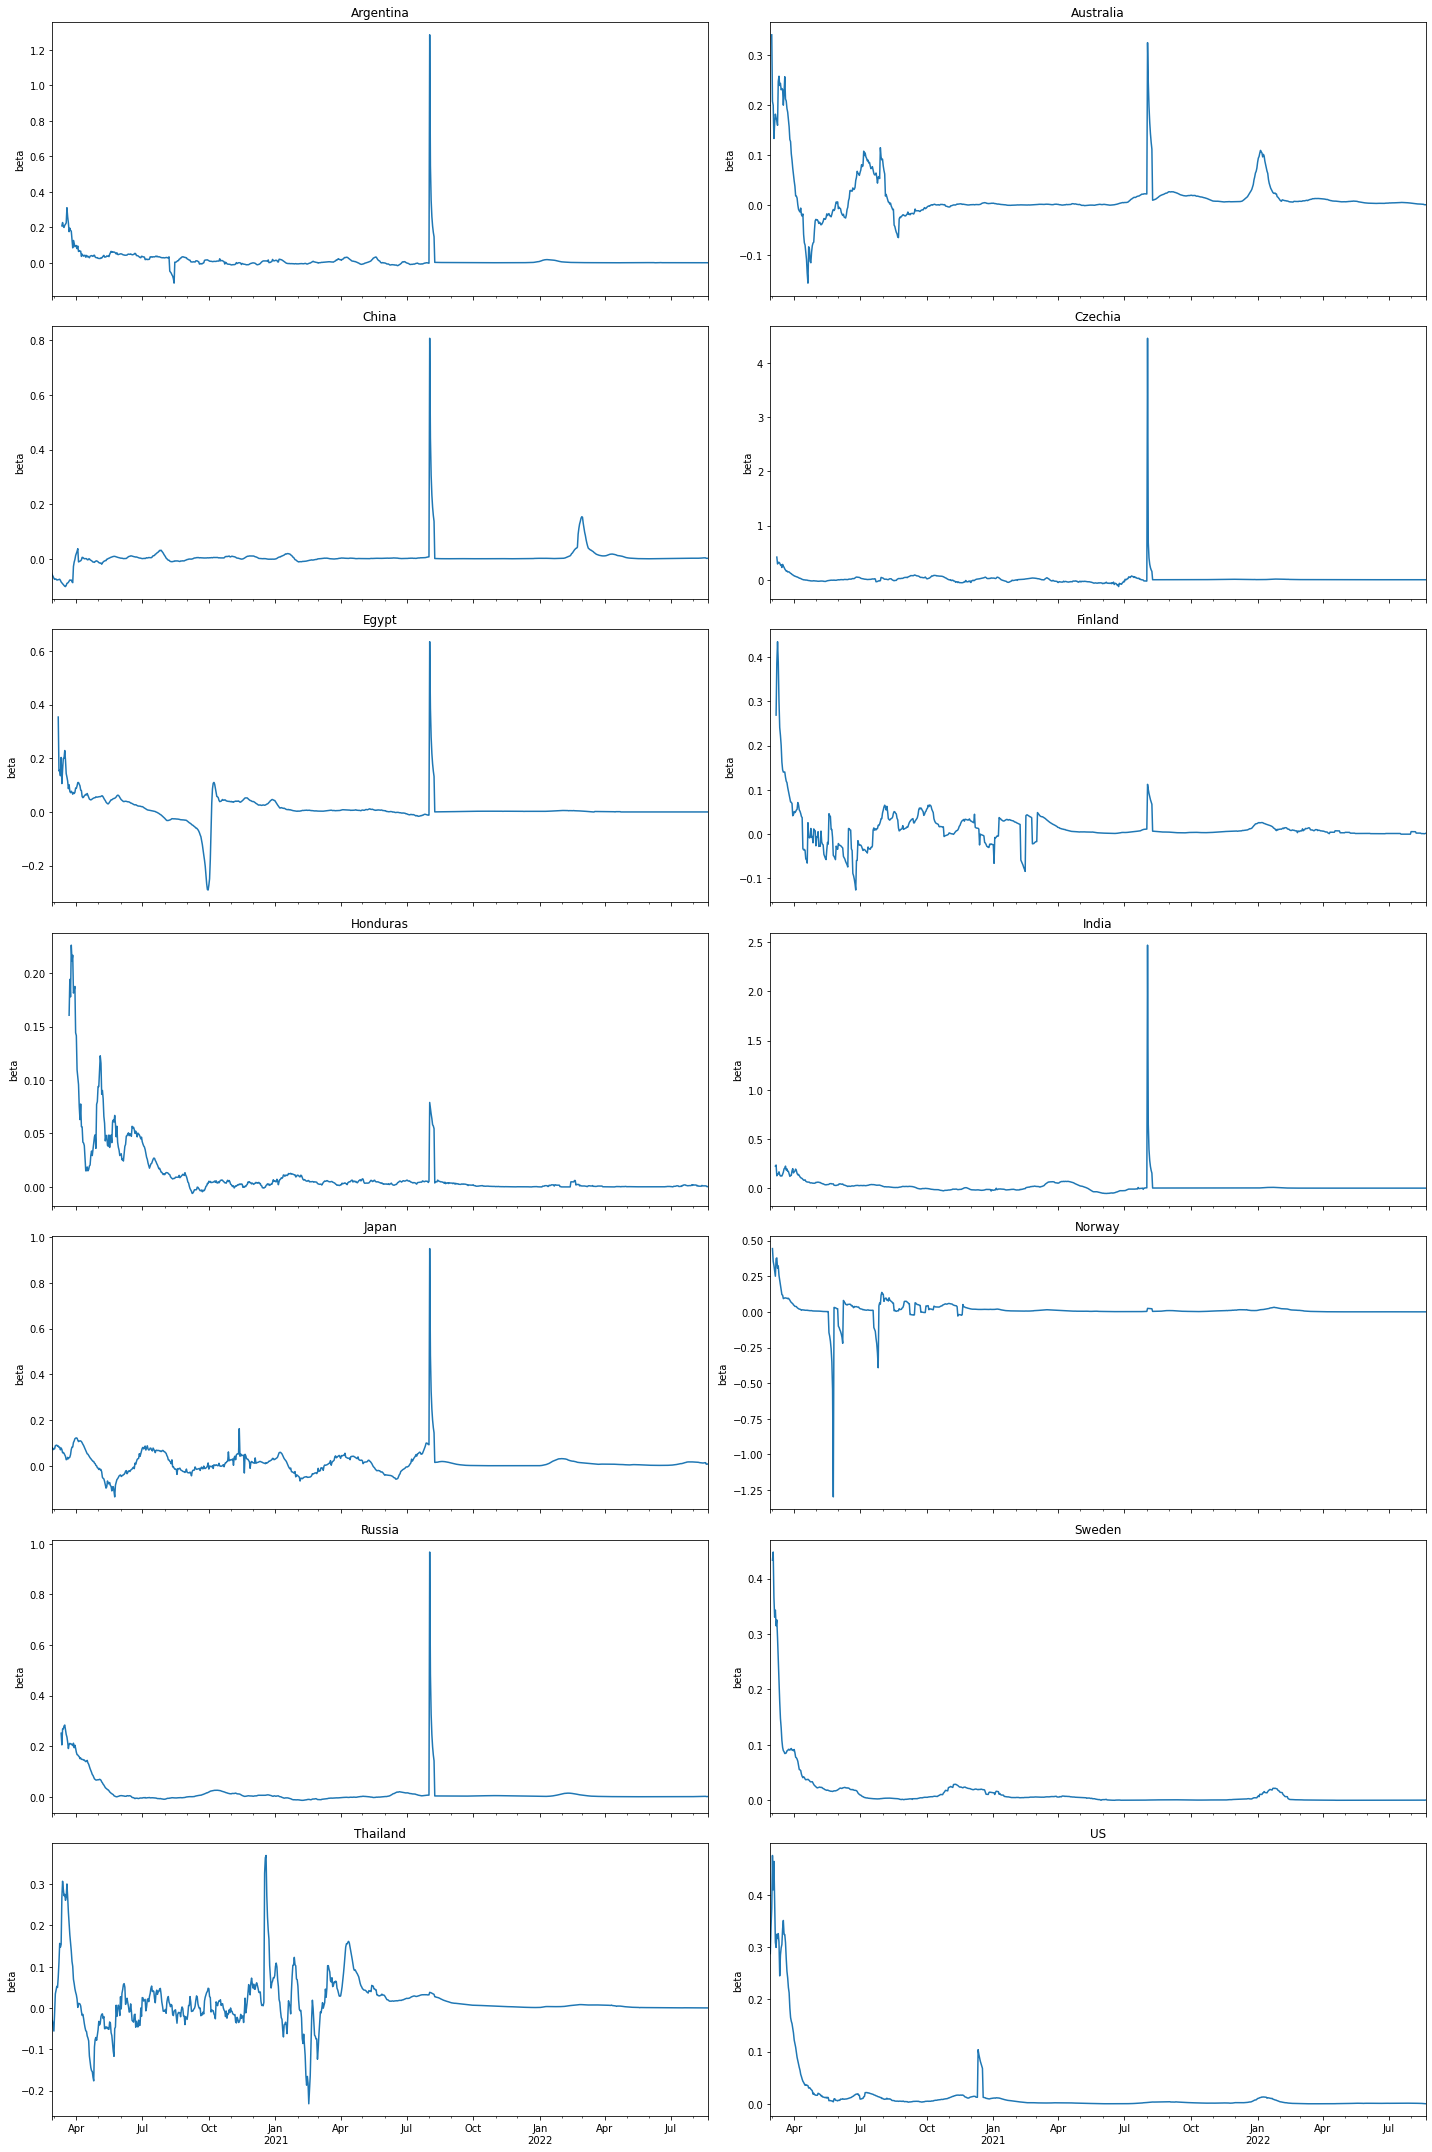

In [67]:
fig, axs = multiple_plot(cc_dict.values(), [gr], xa=xa, ylabel='beta')
fig.tight_layout()

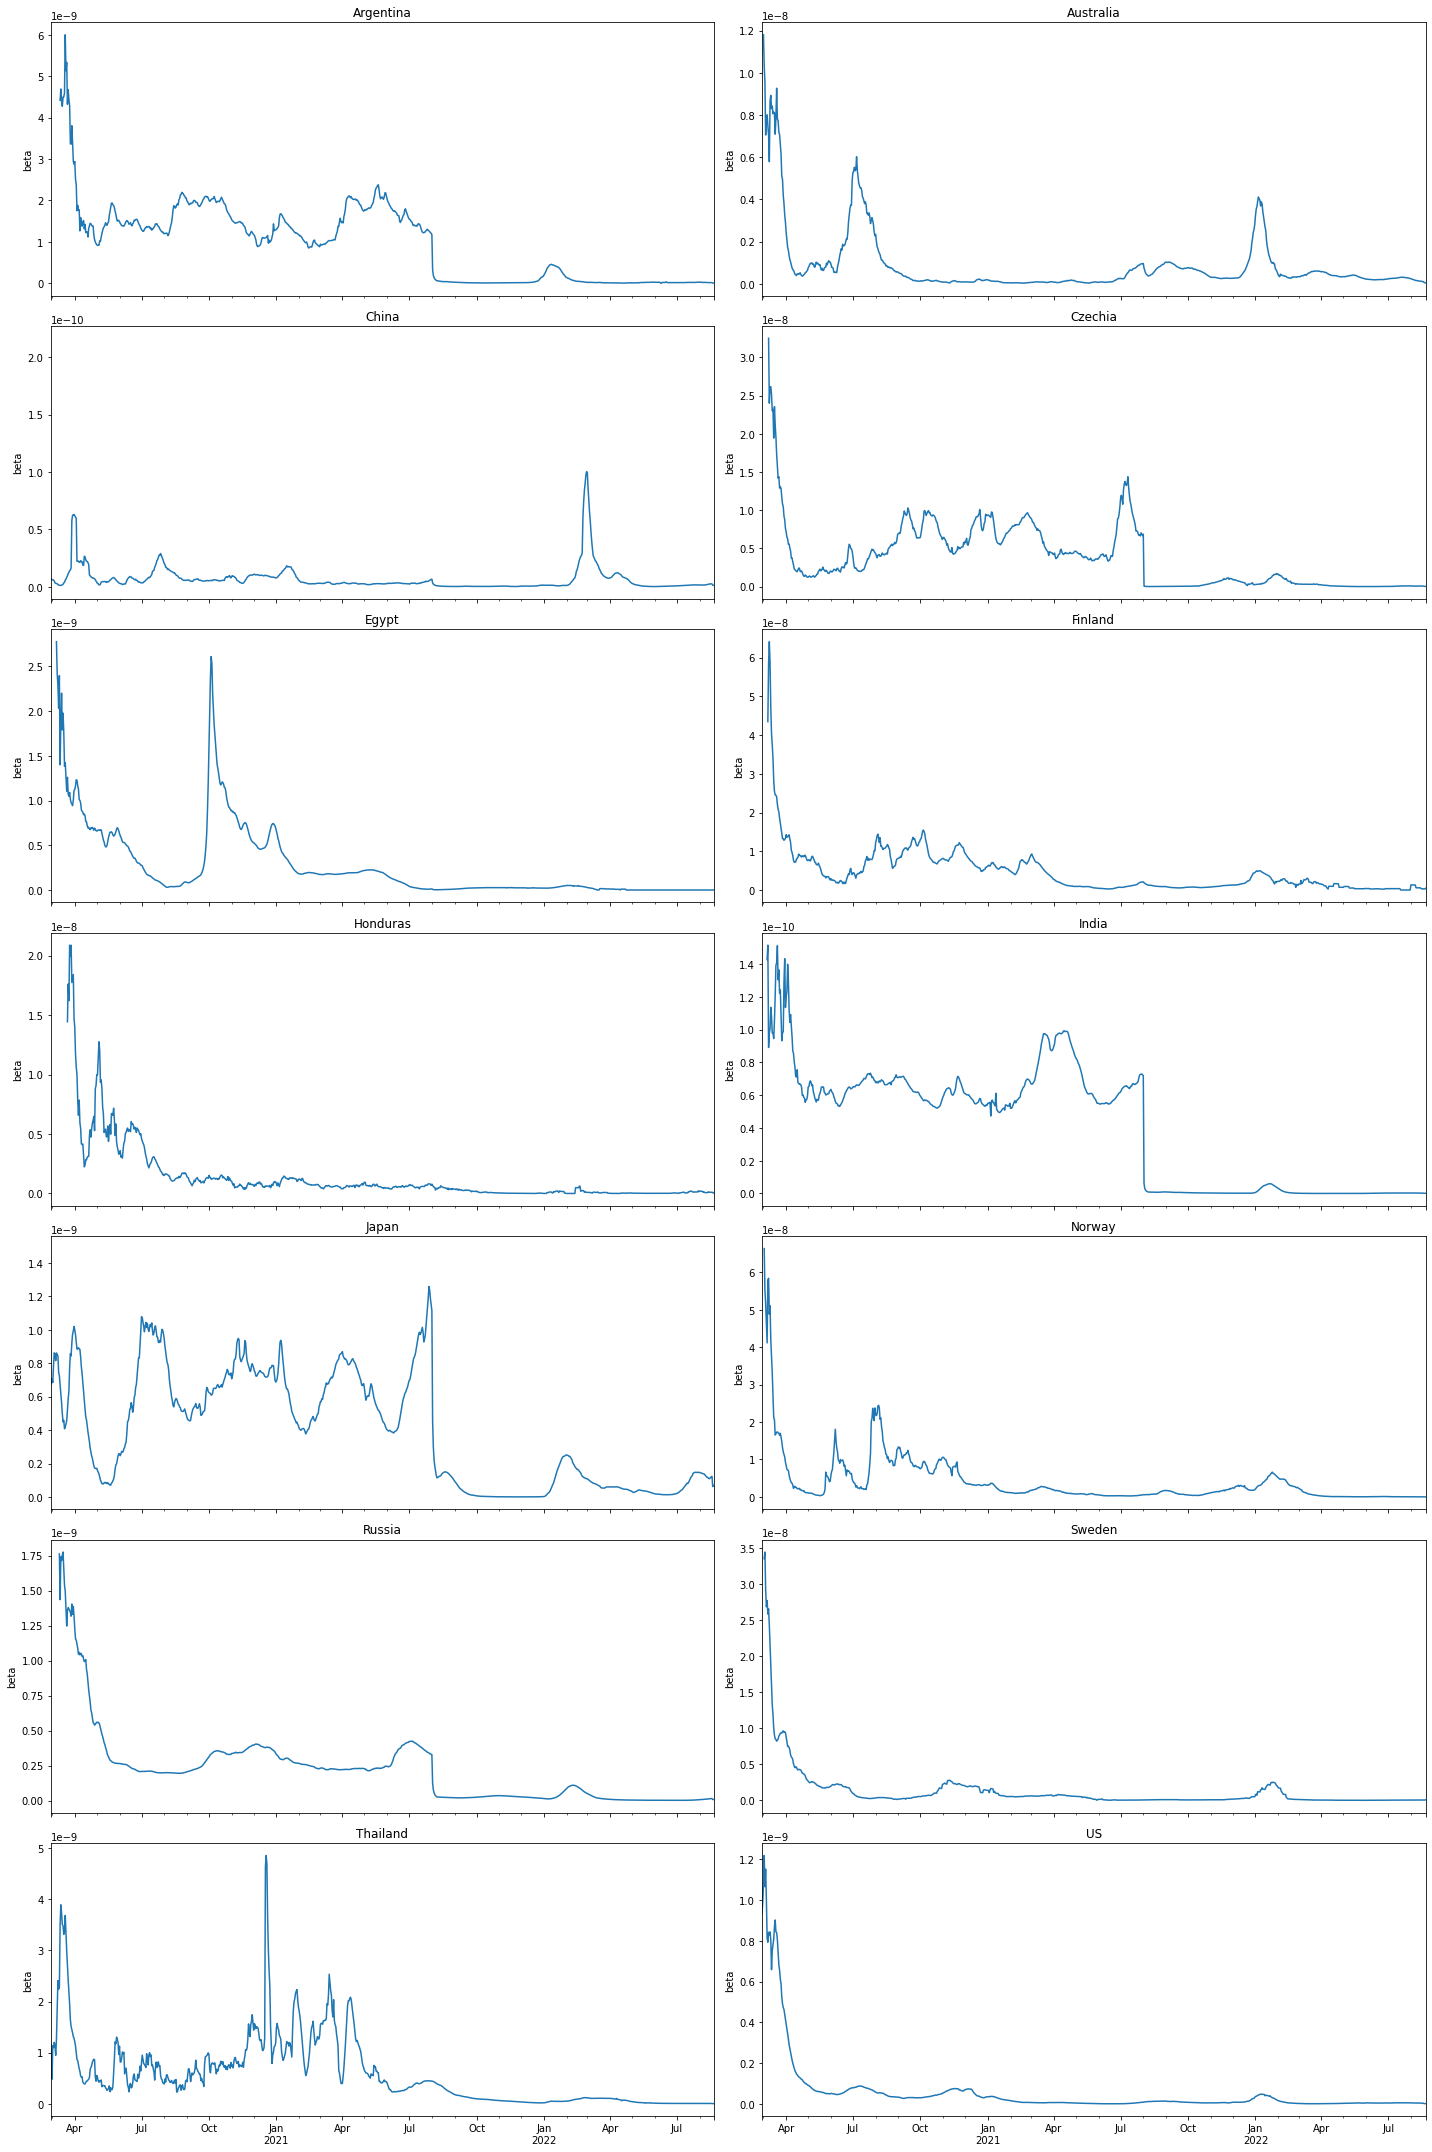

In [68]:
fig, axs = multiple_plot(cc_dict.values(), [beta], xa=xa, ylabel='beta')
fig.tight_layout()

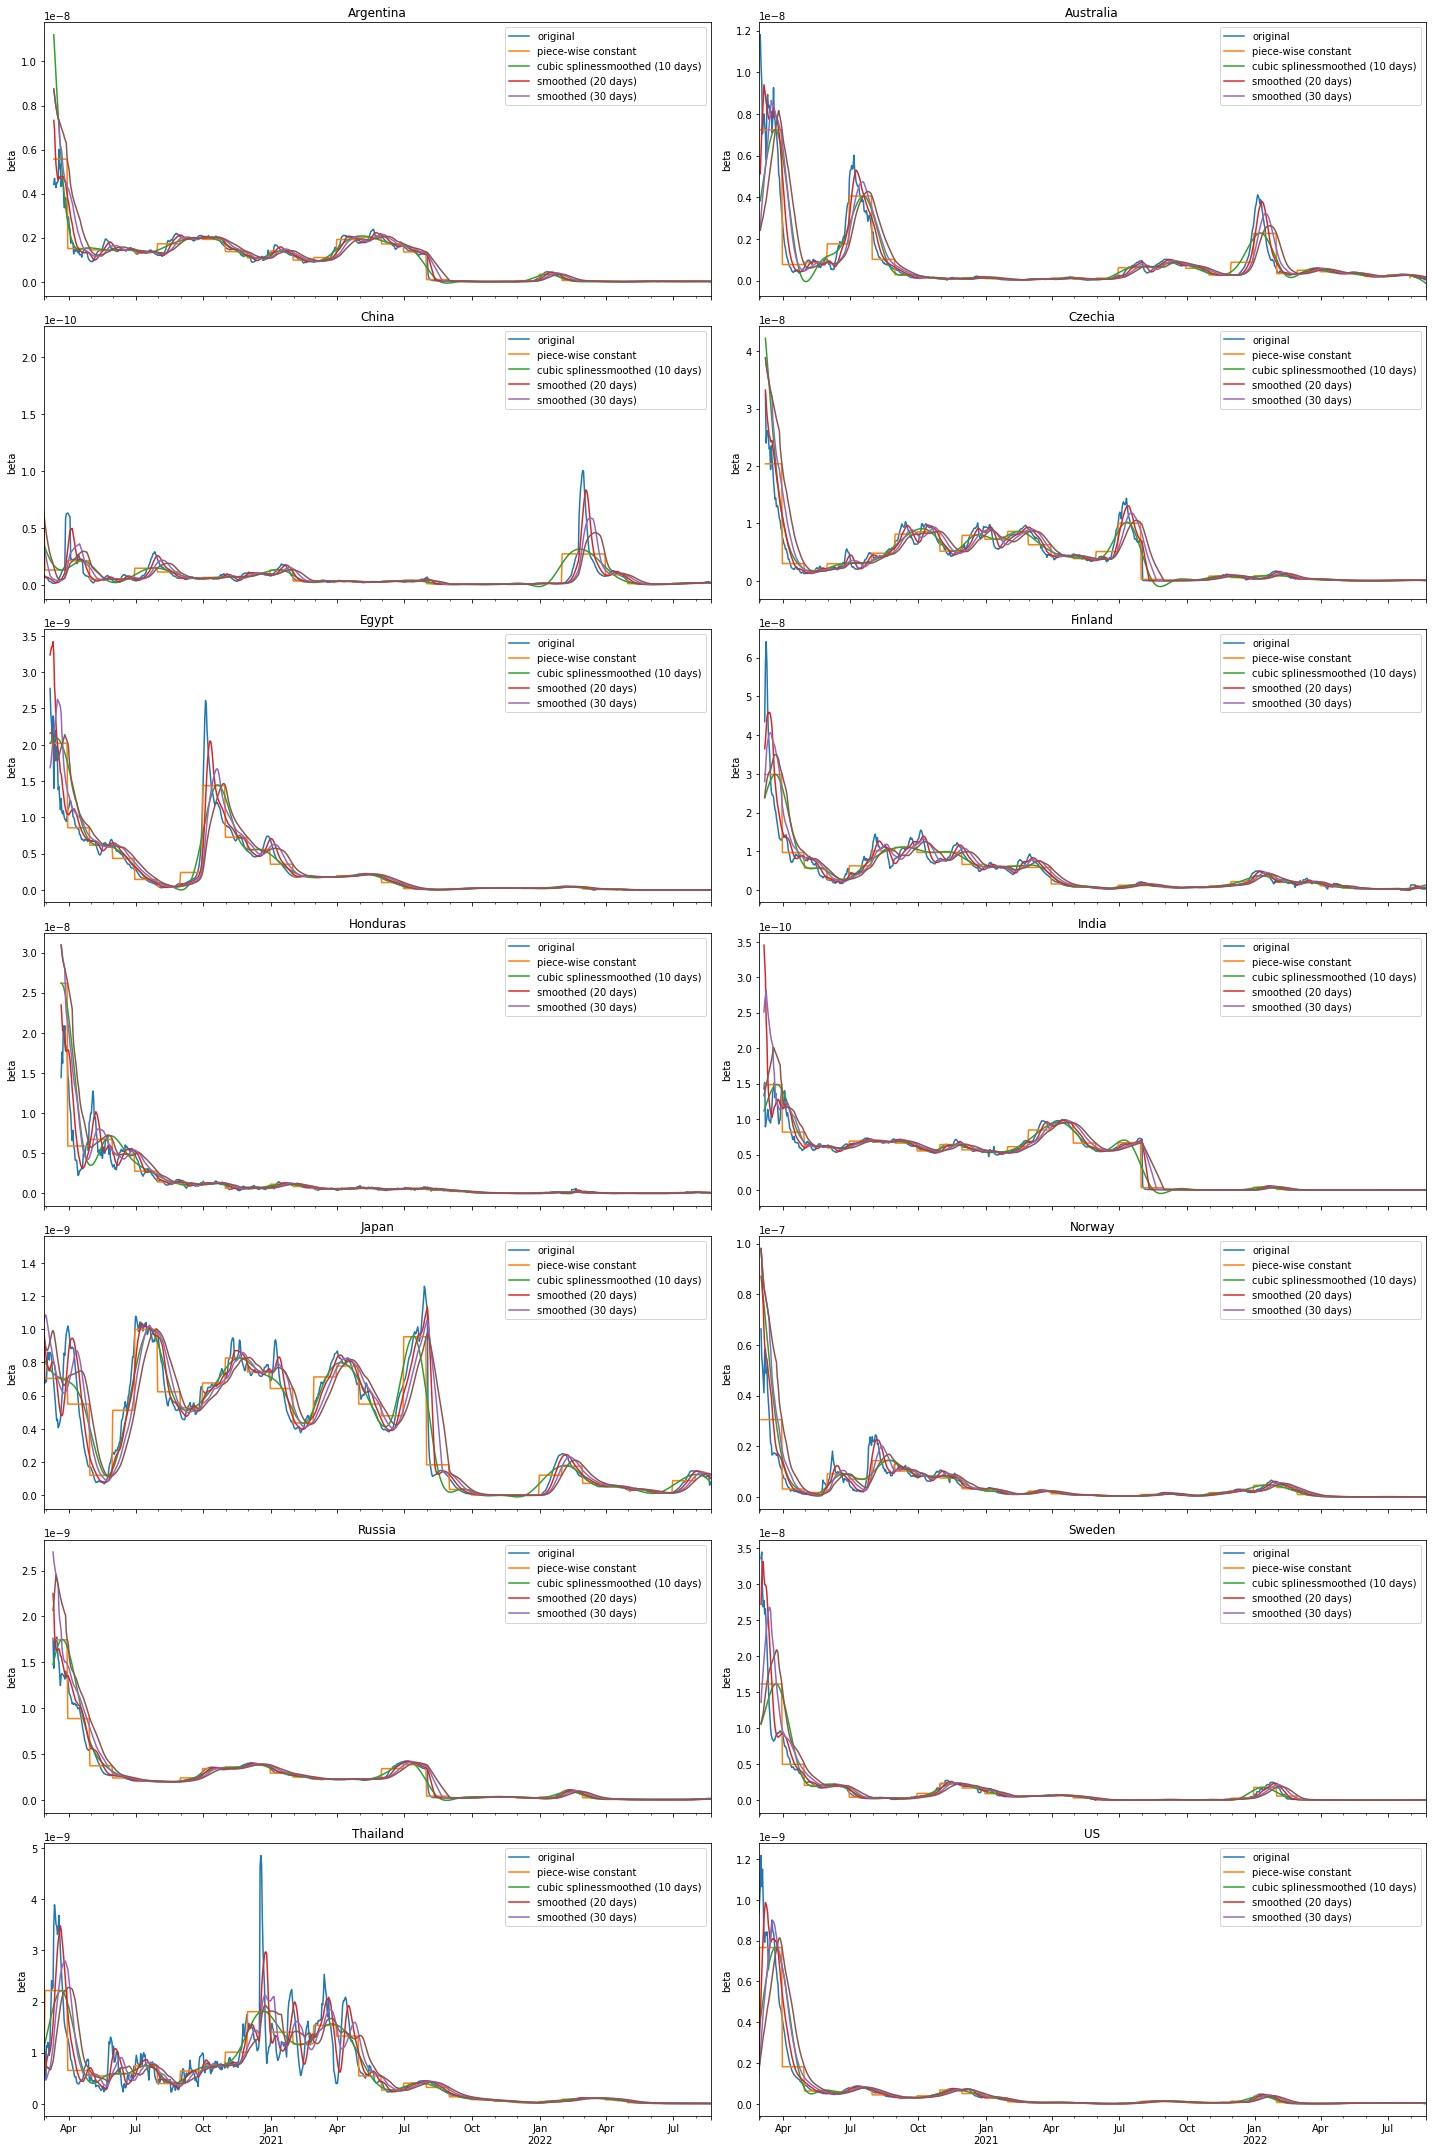

In [69]:
betas = [beta, beta_cst, beta_spl, beta_smooth_10, beta_smooth_20, beta_smooth_30]
legend = [
  'original', 'piece-wise constant', 'cubic splines'
  'smoothed (10 days)', 'smoothed (20 days)', 'smoothed (30 days)'
  ]

fig, axs = multiple_plot(cc_dict.values(), betas, xa=xa, ylabel='beta', legend=legend)
fig.tight_layout()

# Missing values

Denoted in `pandas` as *Not a Number* (`NaN`) in numeric columns.

In [70]:
print('Missing values per indicator:')
print(' - C1:', C1[cc_dict.keys()].isna().sum().sum())
print(' - C2:', C2[cc_dict.keys()].isna().sum().sum())
print(' - C3:', C3[cc_dict.keys()].isna().sum().sum())
print(' - C4:', C4[cc_dict.keys()].isna().sum().sum())
print(' - C5:', C5[cc_dict.keys()].isna().sum().sum())
print(' - C6:', C6[cc_dict.keys()].isna().sum().sum())
print(' - C7:', C7[cc_dict.keys()].isna().sum().sum())
print(' - C8:', C8[cc_dict.keys()].isna().sum().sum())
print(' - H1:', H1[cc_dict.keys()].isna().sum().sum())
print(' - H6:', H6[cc_dict.keys()].isna().sum().sum())

Missing values per indicator:
 - C1: 96
 - C2: 96
 - C3: 96
 - C4: 96
 - C5: 96
 - C6: 96
 - C7: 96
 - C8: 96
 - H1: 96
 - H6: 114


In [71]:
print('Total number of missing values in')
print(' - cases:', cum_cases.isna().sum().sum())
print(' - deaths:', cum_deaths.isna().sum().sum())
print(' - recoveries:', cum_recoveries.isna().sum().sum())

Total number of missing values in
 - cases: 0
 - deaths: 0
 - recoveries: 0


In [72]:
print('Missing values (NaN) in the response')
print(' - growth rate:', gr.isna().sum().sum())
print(' - transmission rate:', beta.isna().sum().sum())

Missing values (NaN) in the response
 - growth rate: 0
 - transmission rate: 221
